# 生成5类非均匀分布的二维数据

导入所需要的库

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_samples

生成5类非均匀分布的二维数据

In [12]:
np.random.seed(42) # 设置随机种子，确保可重复性

def generate_data():
    """ 生成 5 类非均匀分布的二维数据 """
    centers = [(-5, -2), (3, 5), (-2, 6), (6, -4), (1, 1)]
    num_samples = [50, 30, 40, 20, 60]  # 总和 200

    X, y = [], []
    for i, (cx, cy) in enumerate(centers):
        X.append(np.random.randn(num_samples[i], 2) + np.array([cx, cy]))
        y.extend([i] * num_samples[i])

    return np.vstack(X), np.array(y)

# 生成数据
X, y = generate_data()

绘制有标签和无标签的原始数据

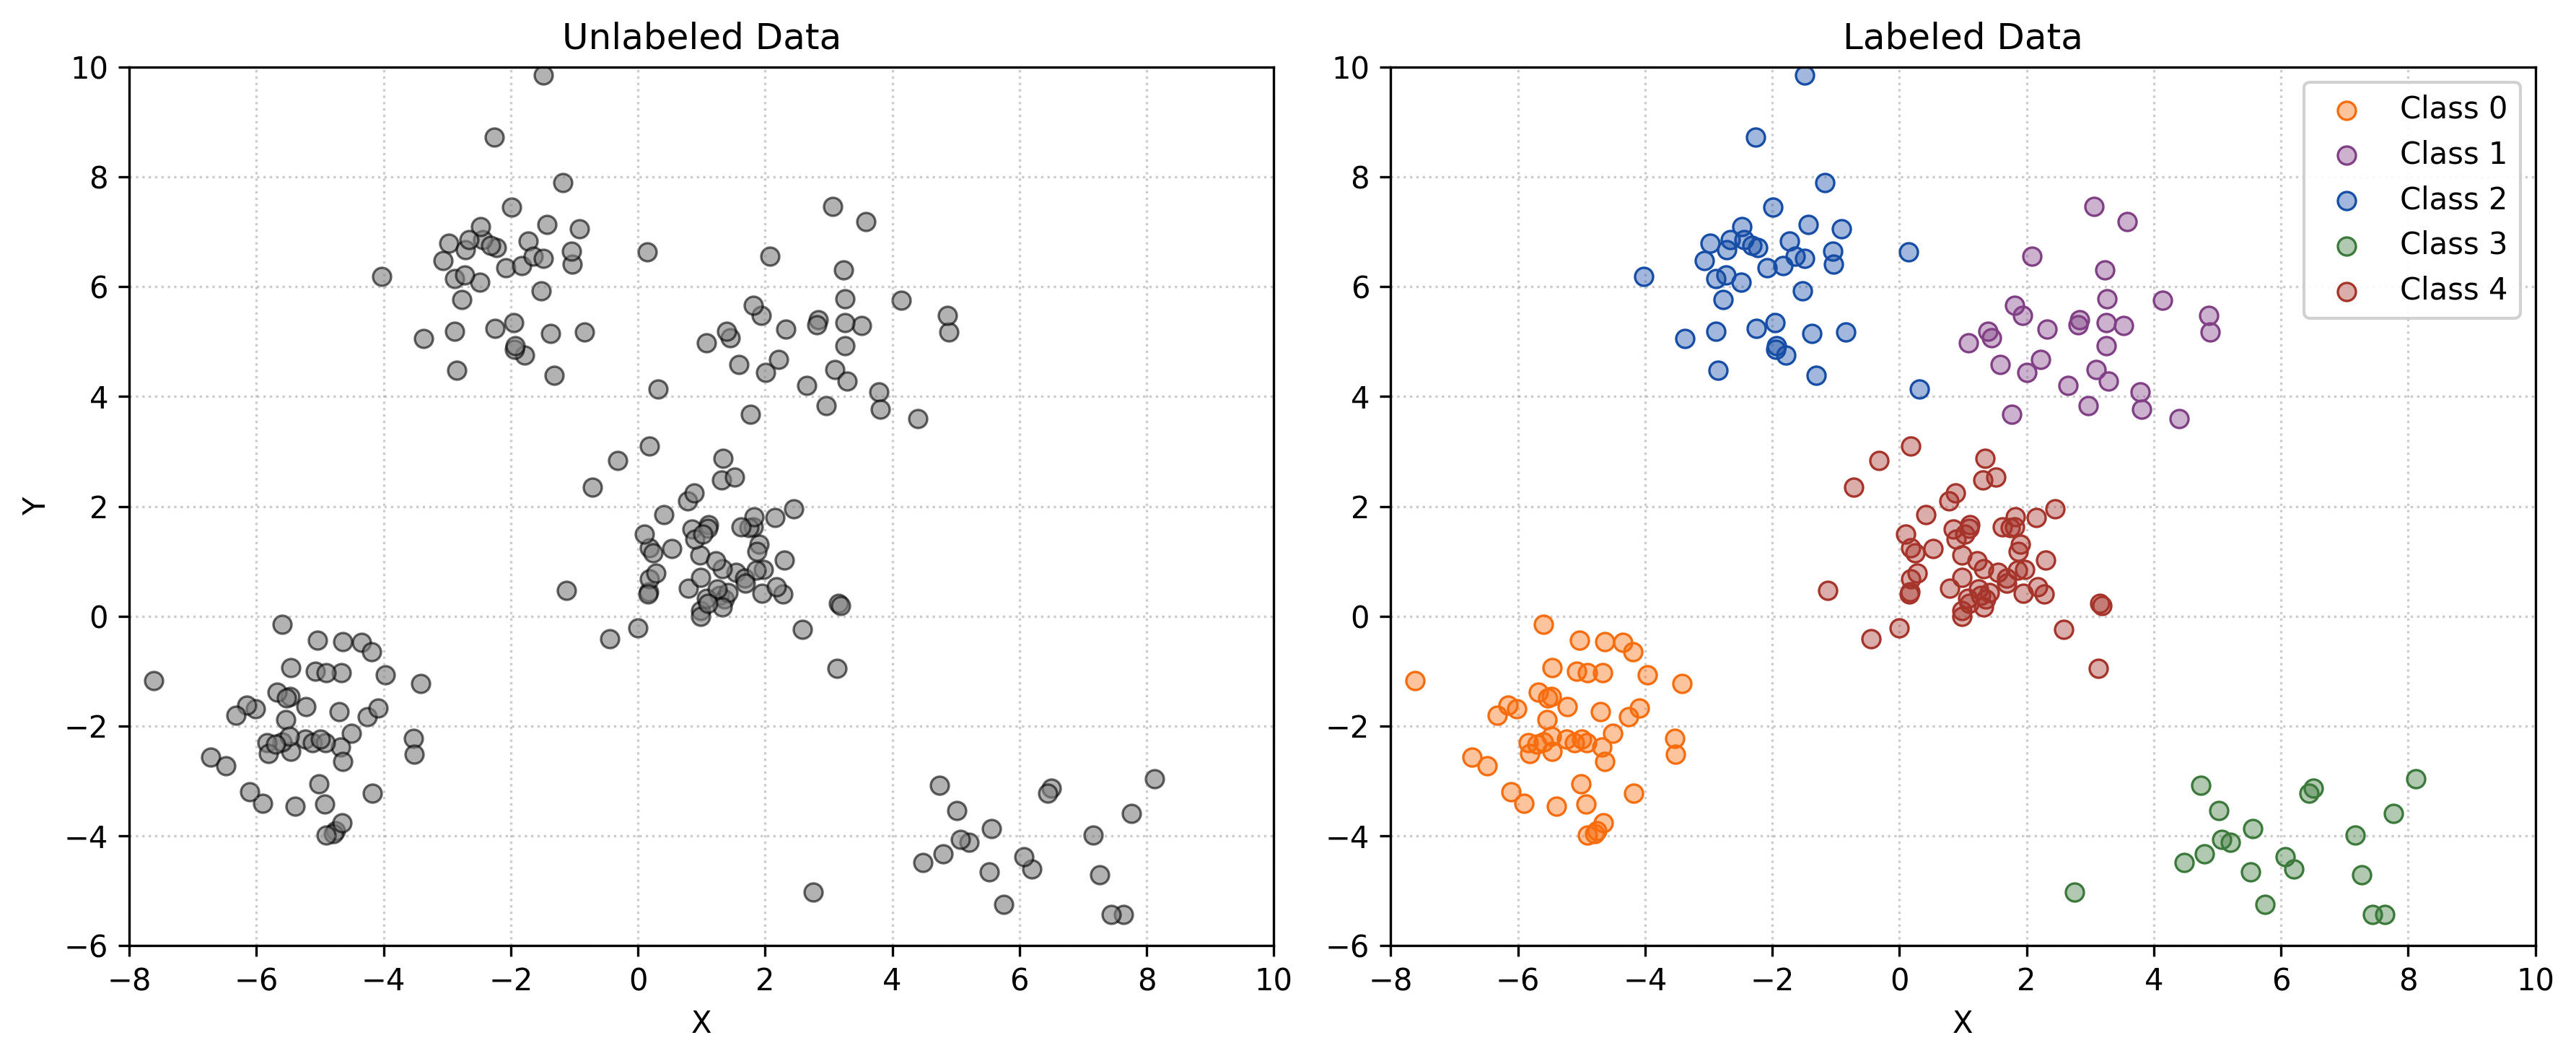

In [13]:
class_colors = [
    (0.970, 0.424, 0.046),   # Class 0
    (0.505, 0.250, 0.520),   # Class 1
    (0.086, 0.302, 0.651),   # Class 2
    (0.235, 0.480, 0.235),   # Class 3
    (0.650, 0.204, 0.169),   # Class 4
    (0.000, 0.392, 0.431),   # Class 5
    (1.000, 0.651, 0.000)    # Class 6
]

def plot_data(X, y, colors):
    """ 绘制无标签和有标签的原始数据 """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

    # 左图：无标签数据
    ax1.scatter(X[:, 0], X[:, 1], 
                c='grey', edgecolor='black', alpha=0.6, linewidths=0.8)
    ax1.set(xlabel="X", ylabel="Y", title="Unlabeled Data")

    # 右图：带标签数据
    for i in range(5):
        ax2.scatter(X[y == i, 0], X[y == i, 1],
                    facecolors=[(*colors[i], 0.4)],  
                    edgecolors=[colors[i]], linewidths=0.8, label=f'Class {i}', zorder=2)               

    ax2.legend(loc='upper right', framealpha=0.9)
    ax2.set(xlabel="X", title="Labeled Data")

    for ax in [ax1, ax2]:
        ax.set(xlim=(-8, 10), ylim=(-6, 10))
        ax.grid(True, linestyle=':', color='gray', alpha=0.4)

    plt.tight_layout()
    plt.show()

# 绘制数据
plot_data(X, y, class_colors)

# K-means聚类分析

单次分类的过程（K=3）

In [14]:
def plot_kmeans_iterations(X, k=3, max_iter=20):
    """ 逐步展示 K-Means 聚类的迭代过程，每次迭代输出一张单独的图片 """
    kmeans = KMeans(n_clusters=k, init='random', n_init=1, max_iter=max_iter, random_state=42)
    kmeans.fit(X)  # 先运行 KMeans

    for iteration in range(1, max_iter + 1):  # 迭代 1 到 max_iter
        kmeans.set_params(max_iter=iteration)  
        kmeans.fit(X)  # 让 KMeans 继续迭代
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_  # 获取当前的质心

        # 画图
        plt.figure(figsize=(6, 5), dpi=300)

        # 绘制数据点
        for i in range(k):
            mask = labels == i
            plt.scatter(X[mask, 0], X[mask, 1],
                        facecolors=[(*class_colors[i], 0.4)],
                        edgecolors=[class_colors[i]],
                        linewidths=0.8, alpha=0.6, label=f'Cluster {i}')

        # 绘制聚类中心，颜色对应
        plt.scatter(centroids[:, 0], centroids[:, 1], 
                    color=[class_colors[i] for i in range(k)], 
                    marker='X', s=200, zorder=3, label='Centroids')

        # 画决策边界
        xx, yy = np.meshgrid(np.linspace(-8, 10, 1000), np.linspace(-6, 10, 1000))
        Z = np.array([np.argmin([np.linalg.norm(x - center) for center in centroids]) for x in np.c_[xx.ravel(), yy.ravel()]])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=np.arange(-0.5, k+0.5), colors='gray', linewidths=0.7, linestyles='solid')

        plt.xlim(-8, 10)
        plt.ylim(-6, 10)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(f"K-Means Iteration {iteration}")
        plt.legend(loc='upper right', framealpha=0.9)
        plt.grid(True, linestyle=':', color='gray', alpha=0.4)

        # 显示当前迭代结果
        plt.show()

# 运行 K-Means 迭代可视化
# plot_kmeans_iterations(X, k=3, max_iter=20)

不同K的聚类分析结果

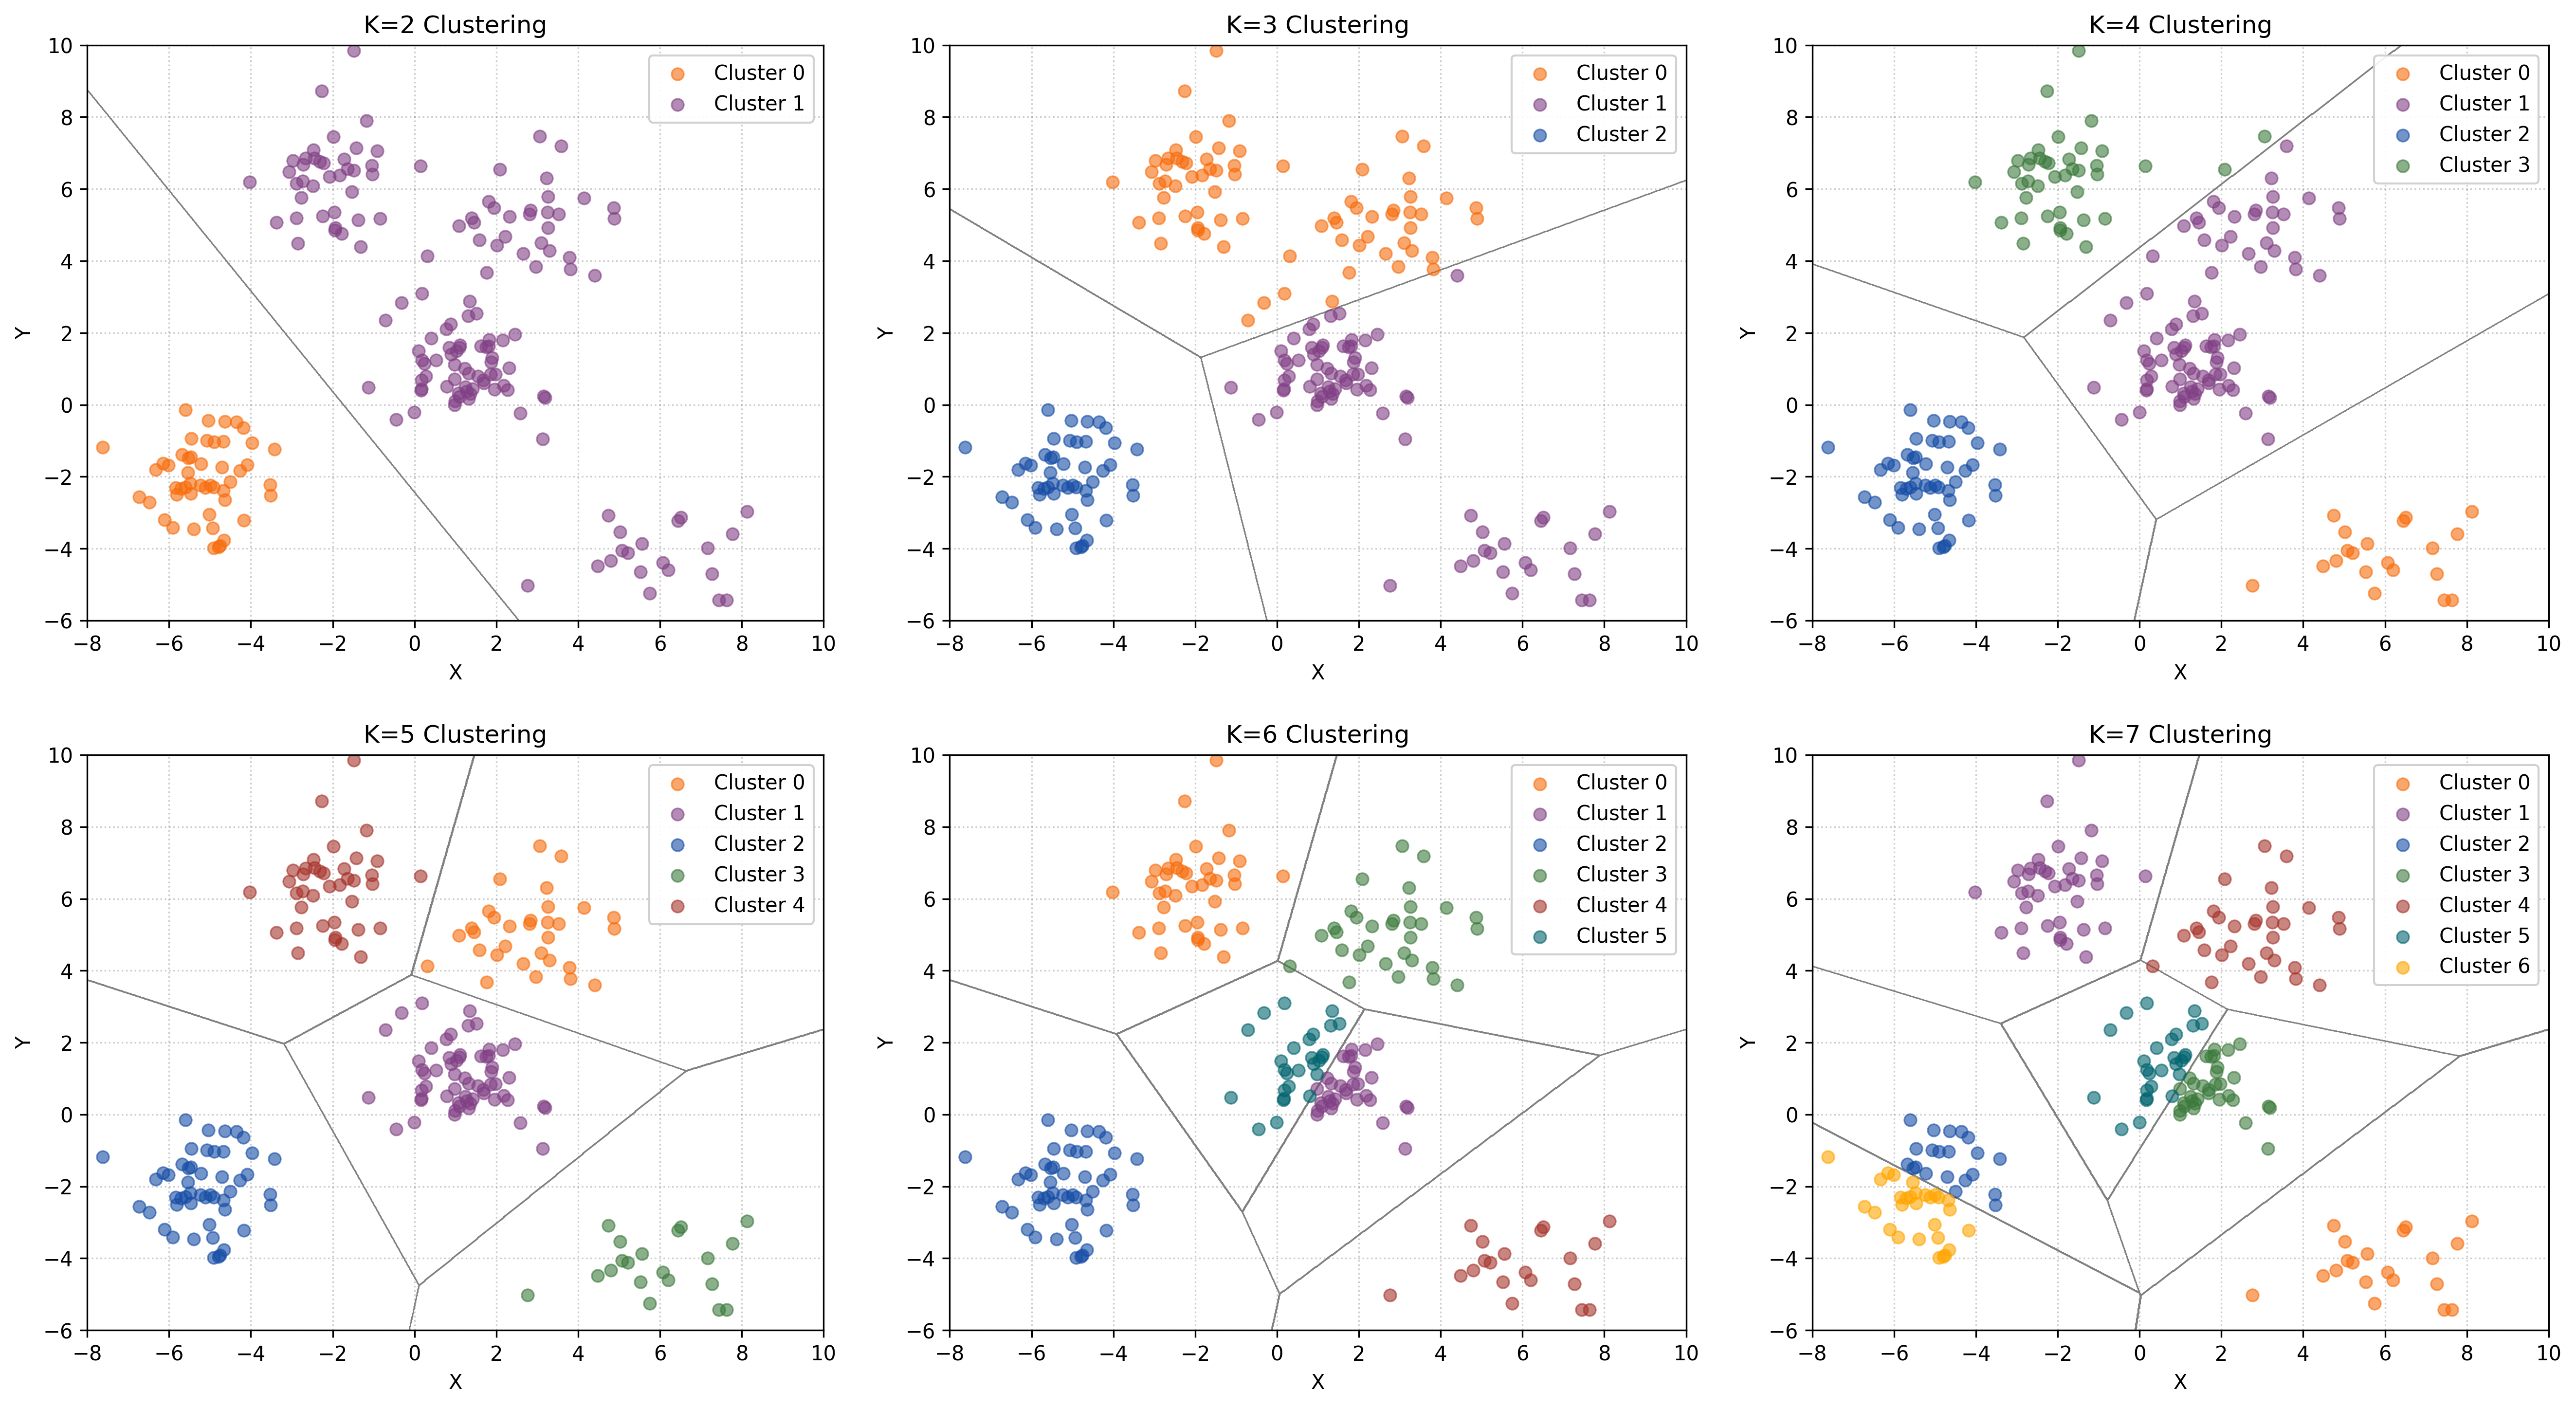

In [15]:
def plot_clusters(ax, X, k, colors):
    """ 可视化 K-Means 聚类结果 """
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)

    xx, yy = np.meshgrid(np.linspace(-8, 10, 1000), 
                         np.linspace(-6, 10, 1000))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # 绘制决策边界
    ax.contour(xx, yy, Z, levels=np.arange(-0.5, k+0.5), colors='gray', linewidths=0.7, linestyles='solid')

    # 绘制聚类数据点
    for i in range(k):
        mask = labels == i
        ax.scatter(X[mask, 0], X[mask, 1],
                   facecolors=[(*colors[i], 0.4)],
                   edgecolors=[colors[i]],
                   linewidths=0.8, alpha=0.6, zorder=2, label=f'Cluster {i}')

def visualize_kmeans(X, colors):
    """ 对不同的 K 值进行 K-Means 聚类并可视化 """
    k_values = range(2, 8)

    n_rows = int(np.ceil(len(k_values) / 3))  # 每行2个子图
    fig, axs = plt.subplots(n_rows, 3, figsize=(12*1.5, 5 * n_rows), dpi=300, squeeze=False)

    for idx, k in enumerate(k_values):
        row, col = divmod(idx, 3)
        plot_clusters(axs[row, col], X, k, colors[:k])
        axs[row, col].set(xlim=(-8, 10), ylim=(-6, 10), xlabel="X", ylabel="Y",
                          xticks=np.arange(-8, 11, 2), yticks=np.arange(-6, 11, 2),
                          title=f"K={k} Clustering")
        axs[row, col].grid(True, linestyle=':', color='gray', alpha=0.4)
        axs[row, col].legend(loc='upper right', framealpha=0.9)

    plt.tight_layout(pad=2.0)
    plt.show()

# 运行 K-Means 并可视化
visualize_kmeans(X, class_colors)

# 确定选择的 K 值

## 方法1: Elbow Method肘部法

K=1  | SSE=5454.9
K=2  | SSE=3093.4
K=3  | SSE=1511.5
K=4  | SSE=740.4
K=5  | SSE=358.0
K=6  | SSE=323.6
K=7  | SSE=291.6
K=8  | SSE=265.6
K=9  | SSE=239.1
K=10 | SSE=219.6


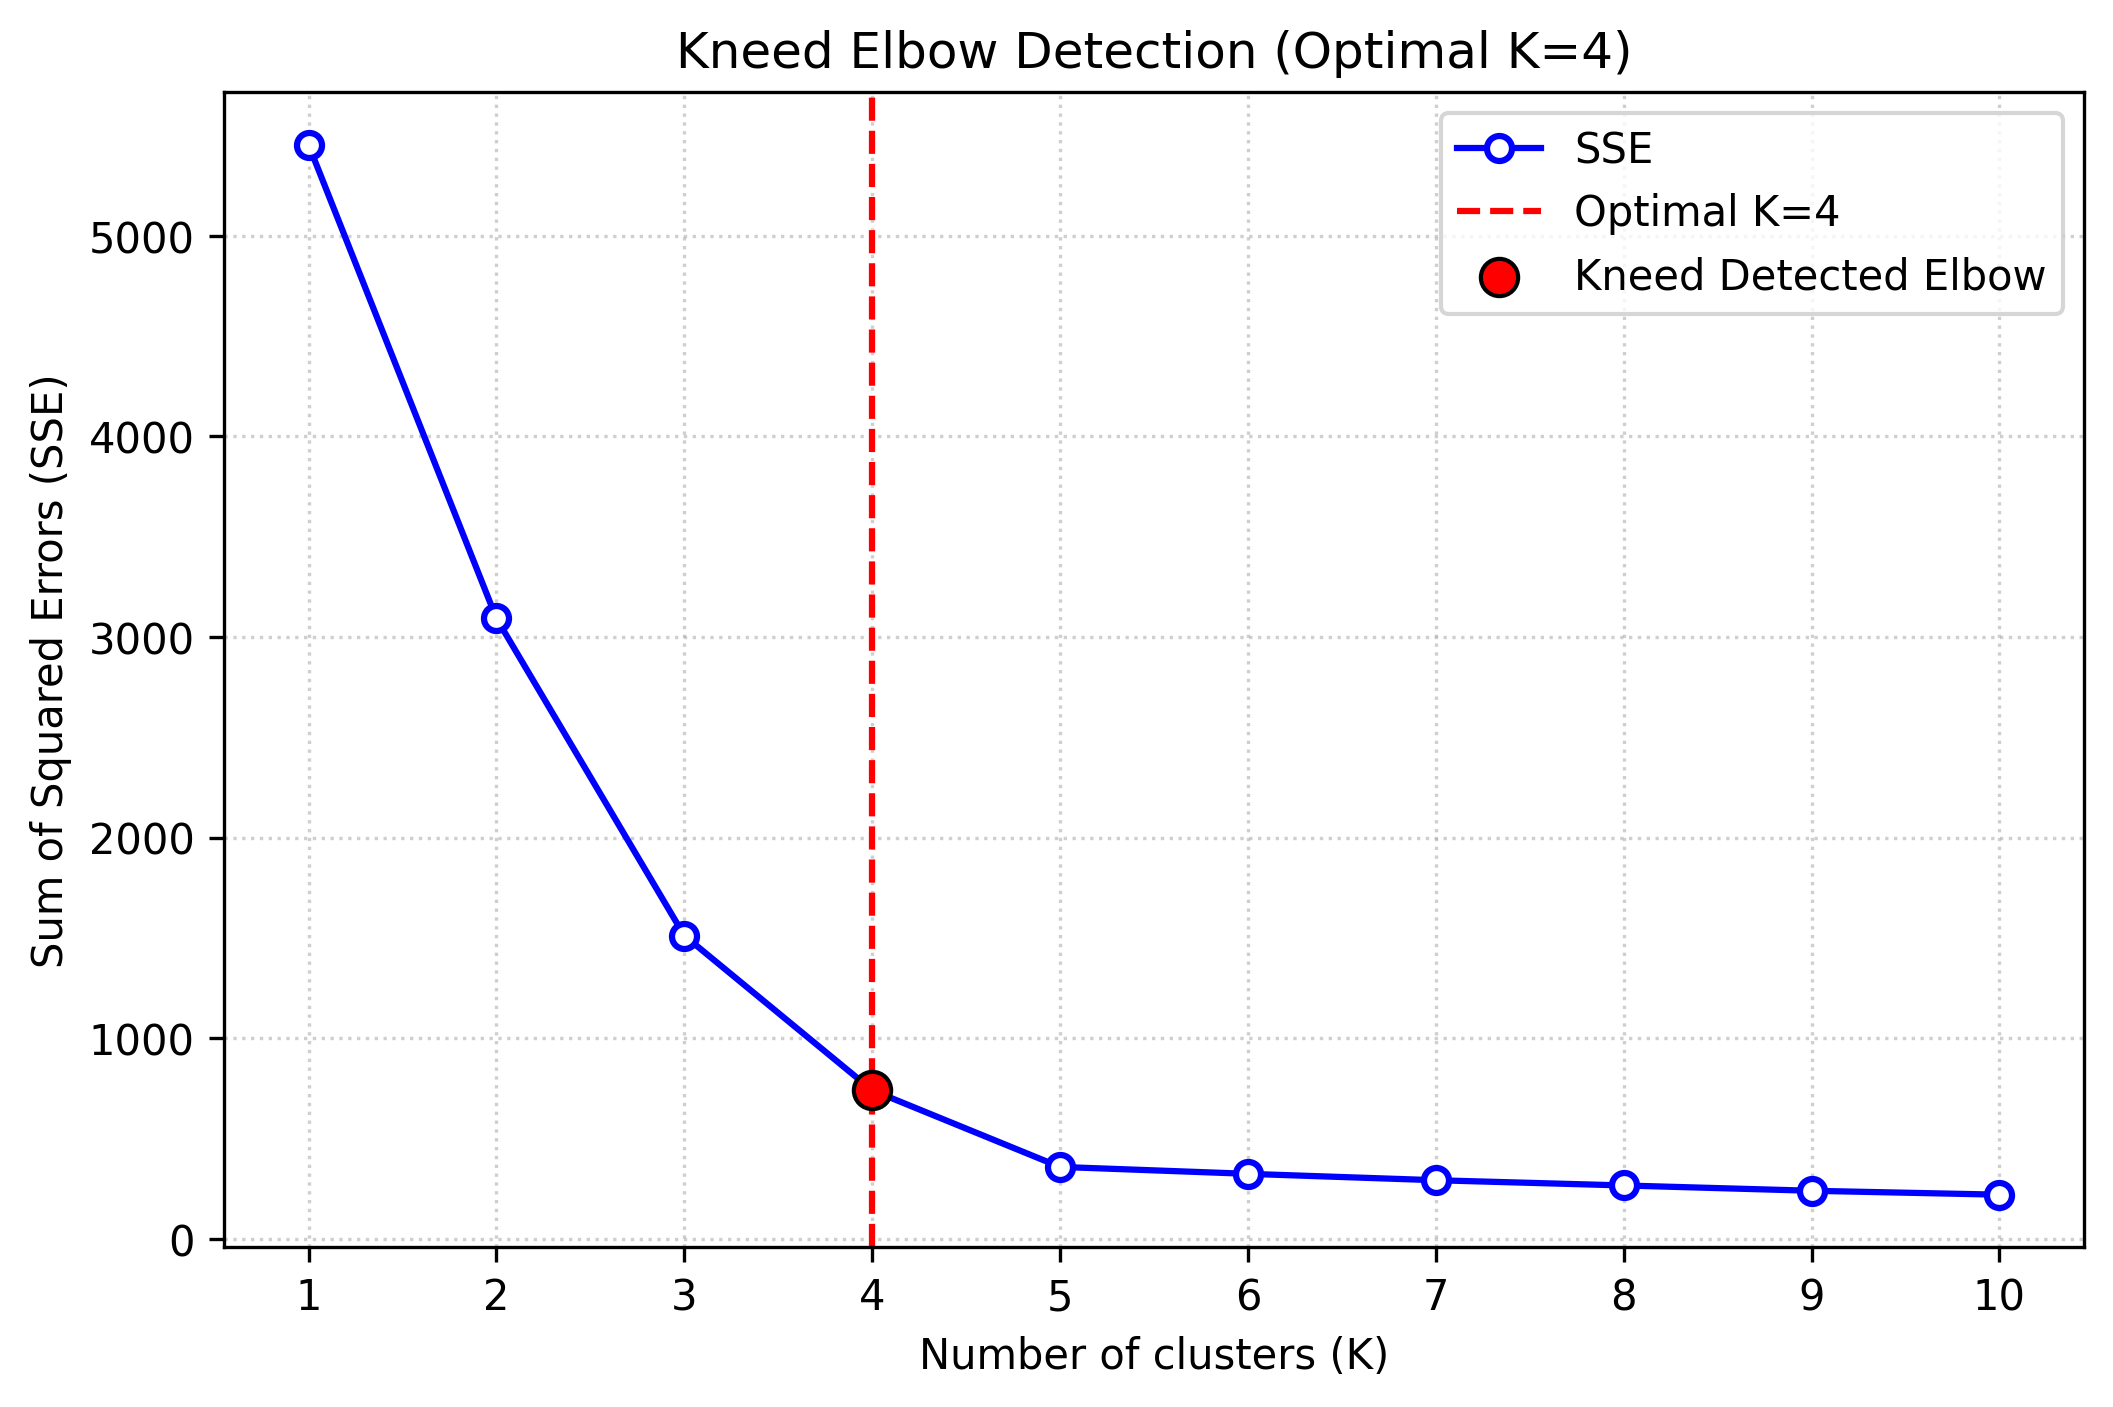

In [16]:
from kneed import KneeLocator  # 导入拐点检测工具

def elbow_method(X, max_k=10):
    """ 使用Elbow方法结合kneed库自动检测拐点 """
    sse = []
    k_values = range(1, max_k + 1)
    
    # 计算各K值的SSE
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
        print(f"K={k:<2} | SSE={kmeans.inertia_:.1f}")

    # 使用kneed自动检测拐点
    kneedle = KneeLocator(
        x=k_values,
        y=sse,
        direction='decreasing',  # SSE随K增大而递减
        curve='convex',          # 手肘曲线为凸形
        interp_method='polynomial', # 多项式插值提升精度
        polynomial_degree=5      # 高阶多项式拟合
    )
    best_k = kneedle.elbow
    
    # 可视化
    plt.figure(figsize=(8, 5), dpi=300)
    plt.plot(k_values, sse, 'bo-', markersize=6, linewidth=1.5, 
             markerfacecolor='white', markeredgewidth=1.5, label="SSE")
    
    # 标记kneed检测的拐点
    if best_k is not None:
        plt.axvline(best_k, color='r', linestyle='--', label=f'Optimal K={best_k}')
        plt.scatter(best_k, sse[best_k-1], color='red', s=80, 
                    edgecolors='black', zorder=10, label='Kneed Detected Elbow')
    else:
        print("警告：未检测到明显拐点！")

    plt.xlabel('Number of clusters (K)', fontsize=10)
    plt.ylabel('Sum of Squared Errors (SSE)', fontsize=10)
    plt.title(f'Kneed Elbow Detection (Optimal K={best_k})', fontsize=12)
    plt.xticks(k_values)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    return best_k

# 执行分析
optimal_k = elbow_method(X)


加权SSE尝试

K=1  | Weighted SSE=27.3
K=2  | Weighted SSE=21.7
K=3  | Weighted SSE=20.6
K=4  | Weighted SSE=12.3
K=5  | Weighted SSE=9.4
K=6  | Weighted SSE=9.9
K=7  | Weighted SSE=10.2
K=8  | Weighted SSE=10.8
K=9  | Weighted SSE=10.6
K=10 | Weighted SSE=10.8


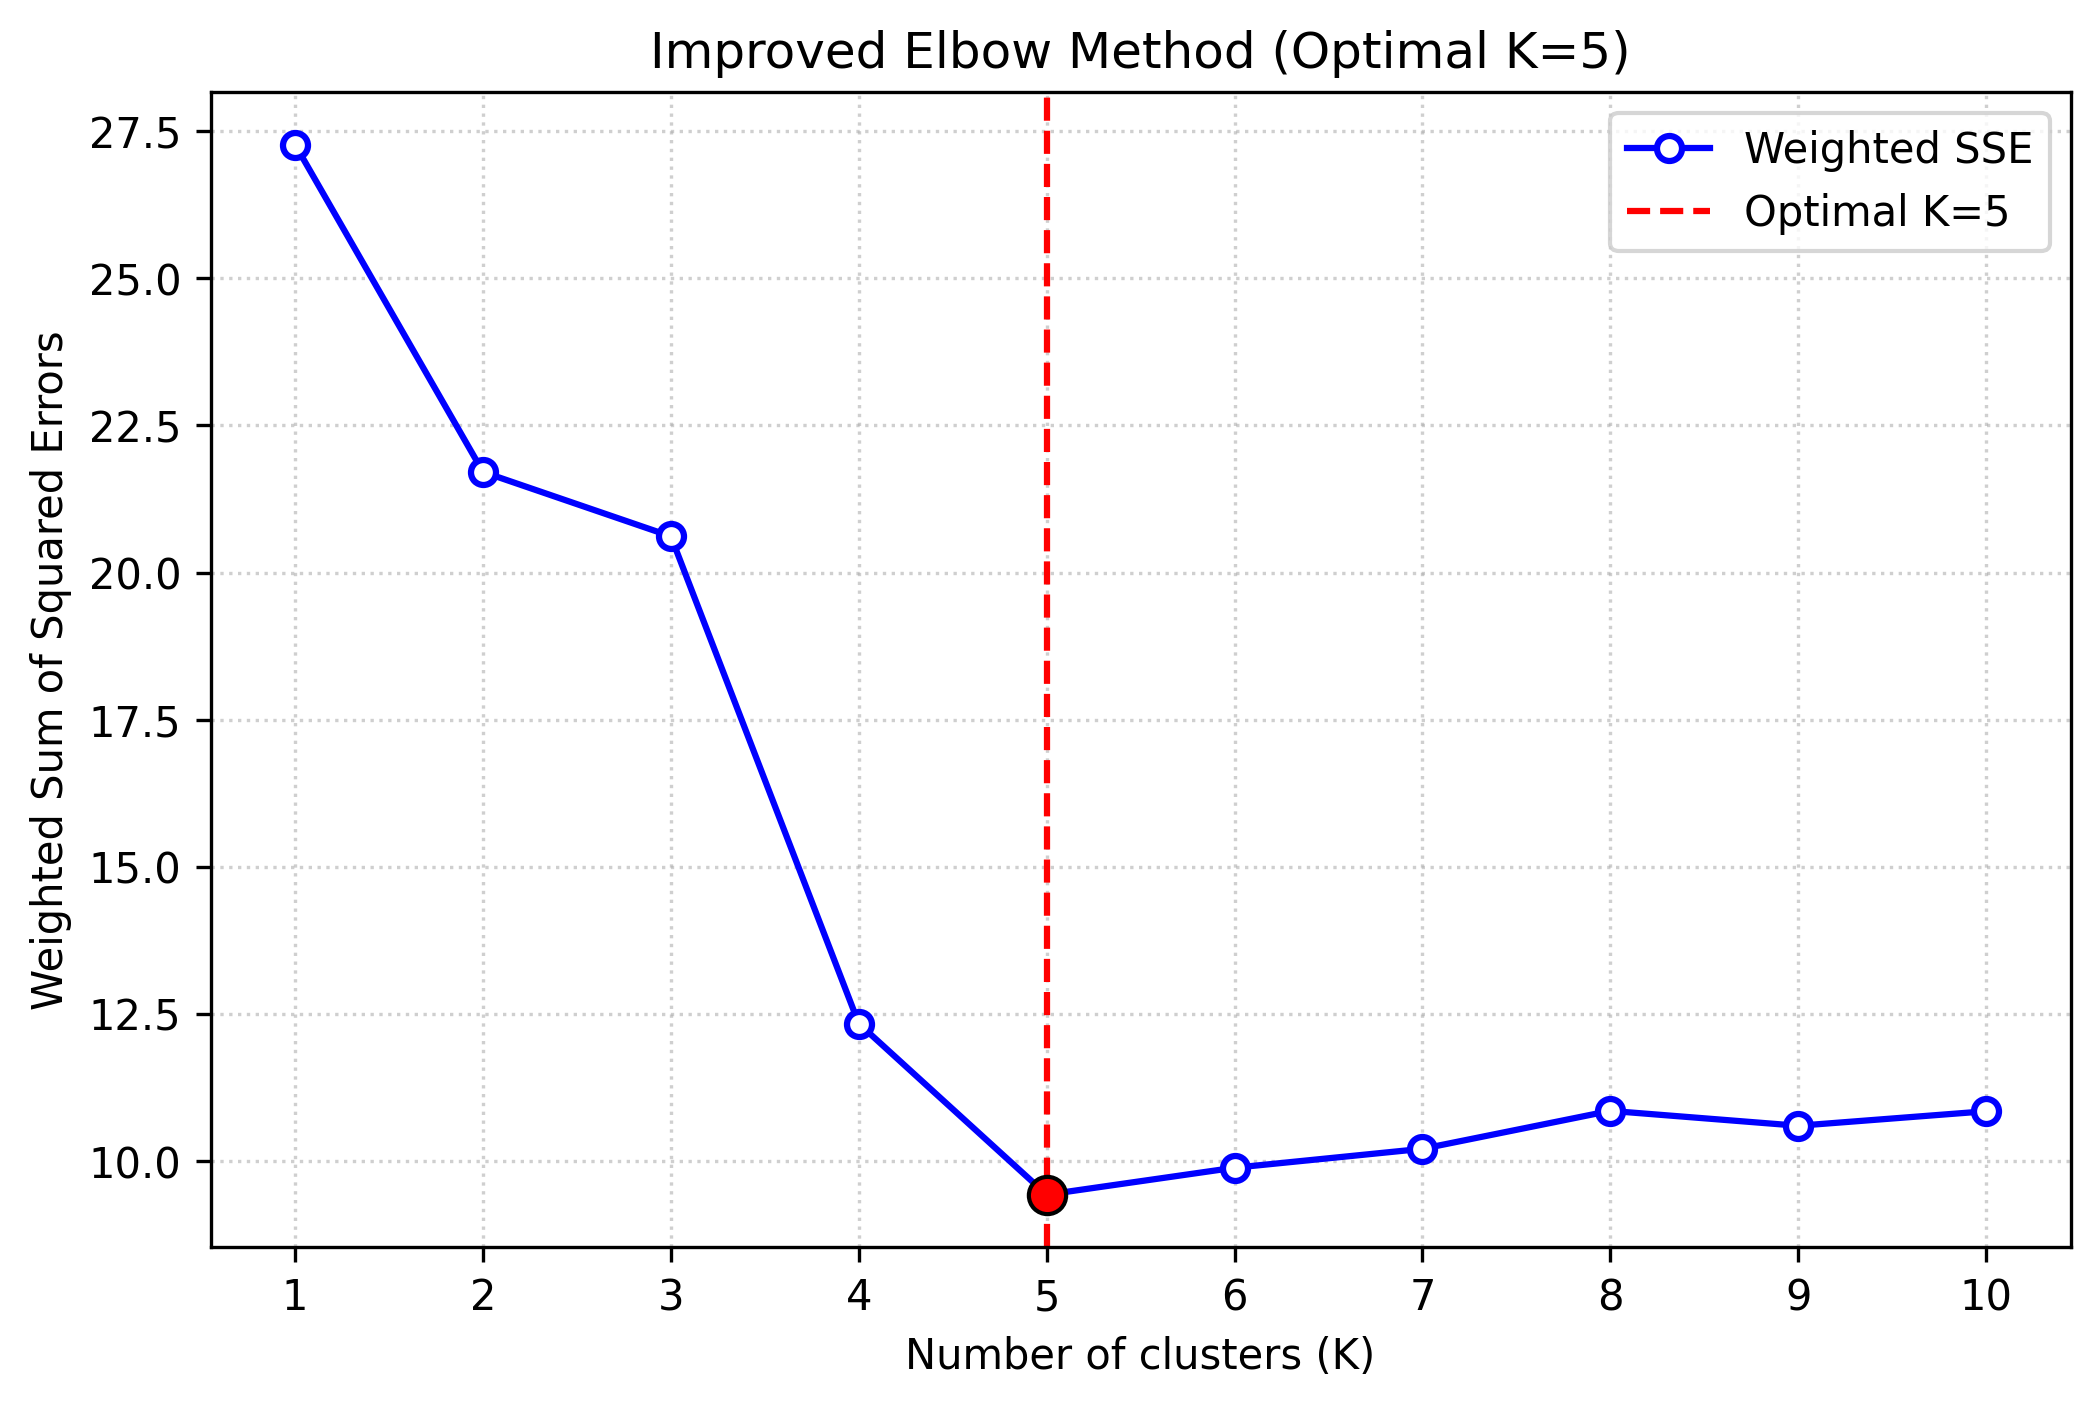

In [ ]:
def weighted_sse(X, labels, weight_type='inverse_size'):
    """ 计算加权簇内平方误差和 """
    clusters = np.unique(labels)
    total_sse = 0.0
    
    for cluster in clusters:
        cluster_points = X[labels == cluster]  # 获取当前簇的所有数据点
        cluster_size = cluster_points.shape[0]
        
        # 计算簇内SSE
        centroid = np.mean(cluster_points, axis=0)
        sse = np.sum((cluster_points - centroid) ** 2)
        
        # 应用权重
        if weight_type == 'inverse_size':
            weight = 1 / cluster_size if cluster_size > 0 else 0
        elif weight_type == 'log_size':
            weight = 1 / np.log(cluster_size + 1)  # +1防止log(0)
        else:
            weight = 1  # 默认无权重
            
        total_sse += weight * sse
        
    return total_sse

def elbow_method(X, max_k=10, weighted=True, weight_type='inverse_size'):
    """ 改进的肘部法（支持加权SSE） """
    sse = []
    k_values = range(1, max_k + 1)
    
    # 计算各K值的SSE
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(X)
        
        if weighted:
            # 计算加权SSE
            weighted_sse_val = weighted_sse(X, kmeans.labels_, weight_type=weight_type)
            sse.append(weighted_sse_val)
            print(f"K={k:<2} | Weighted SSE={weighted_sse_val:.1f}")
        else:
            # 原始SSE
            sse.append(kmeans.inertia_)
            print(f"K={k:<2} | SSE={kmeans.inertia_:.1f}")

    # 动态调整Kneed参数
    noise_level = np.std(np.diff(sse)) / np.mean(np.abs(np.diff(sse)))
    interp_method = 'polynomial' if noise_level > 0.3 else 'linear'
    
    kneedle = KneeLocator(
        x=k_values,
        y=sse,
        direction='decreasing',
        curve='convex',
        interp_method=interp_method,
        polynomial_degree=5 if interp_method=='polynomial' else 3,
        S=1.5 if max_k > 8 else 1.0  # 自动调整灵敏度
    )
    best_k = kneedle.elbow
    
    # 可视化
    plt.figure(figsize=(8, 5), dpi=300)
    plt.plot(k_values, sse, 'bo-', markersize=6, linewidth=1.5,
             markerfacecolor='white', markeredgewidth=1.5, 
             label="Weighted SSE" if weighted else "SSE")
    
    if best_k is not None:
        plt.axvline(best_k, color='r', linestyle='--', label=f'Optimal K={best_k}')
        plt.scatter(best_k, sse[best_k-1], color='red', s=80, 
                    edgecolors='black', zorder=10)
    else:
        print("警告：未检测到明显拐点！")

    plt.xlabel('Number of clusters (K)', fontsize=10)
    plt.ylabel('Weighted Sum of Squared Errors' if weighted else 'SSE', fontsize=10)
    plt.title(f'Improved Elbow Method (Optimal K={best_k})', fontsize=12)
    plt.xticks(k_values)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    return best_k

optimal_k = elbow_method(X, max_k=10, weighted=True, weight_type='inverse_size')


## 方法2:轮廓系数法

K=2, Silhouette Score=0.5003


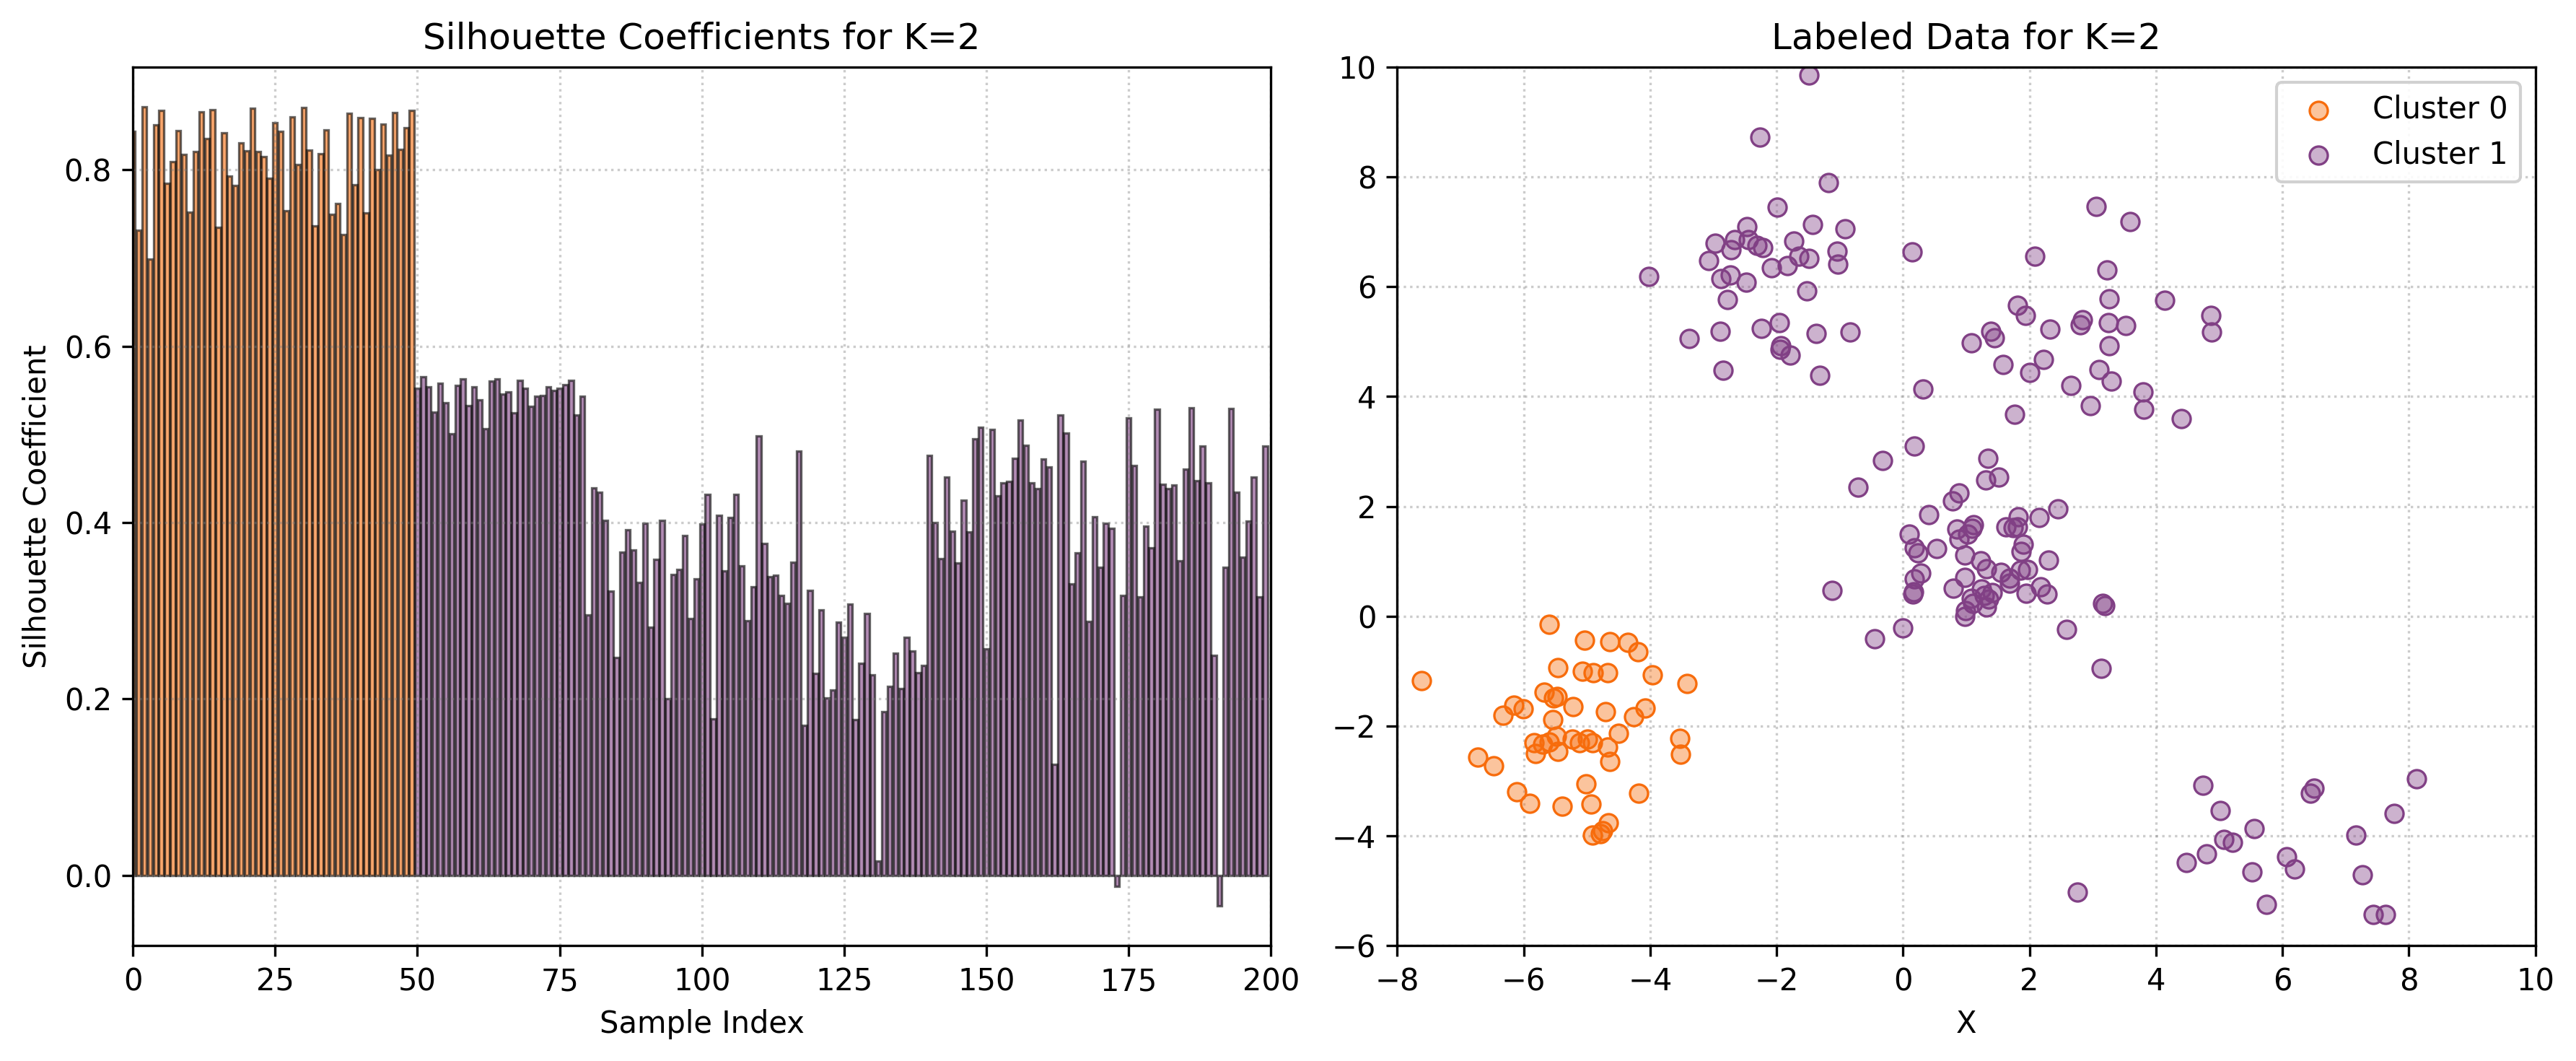

K=3, Silhouette Score=0.5460


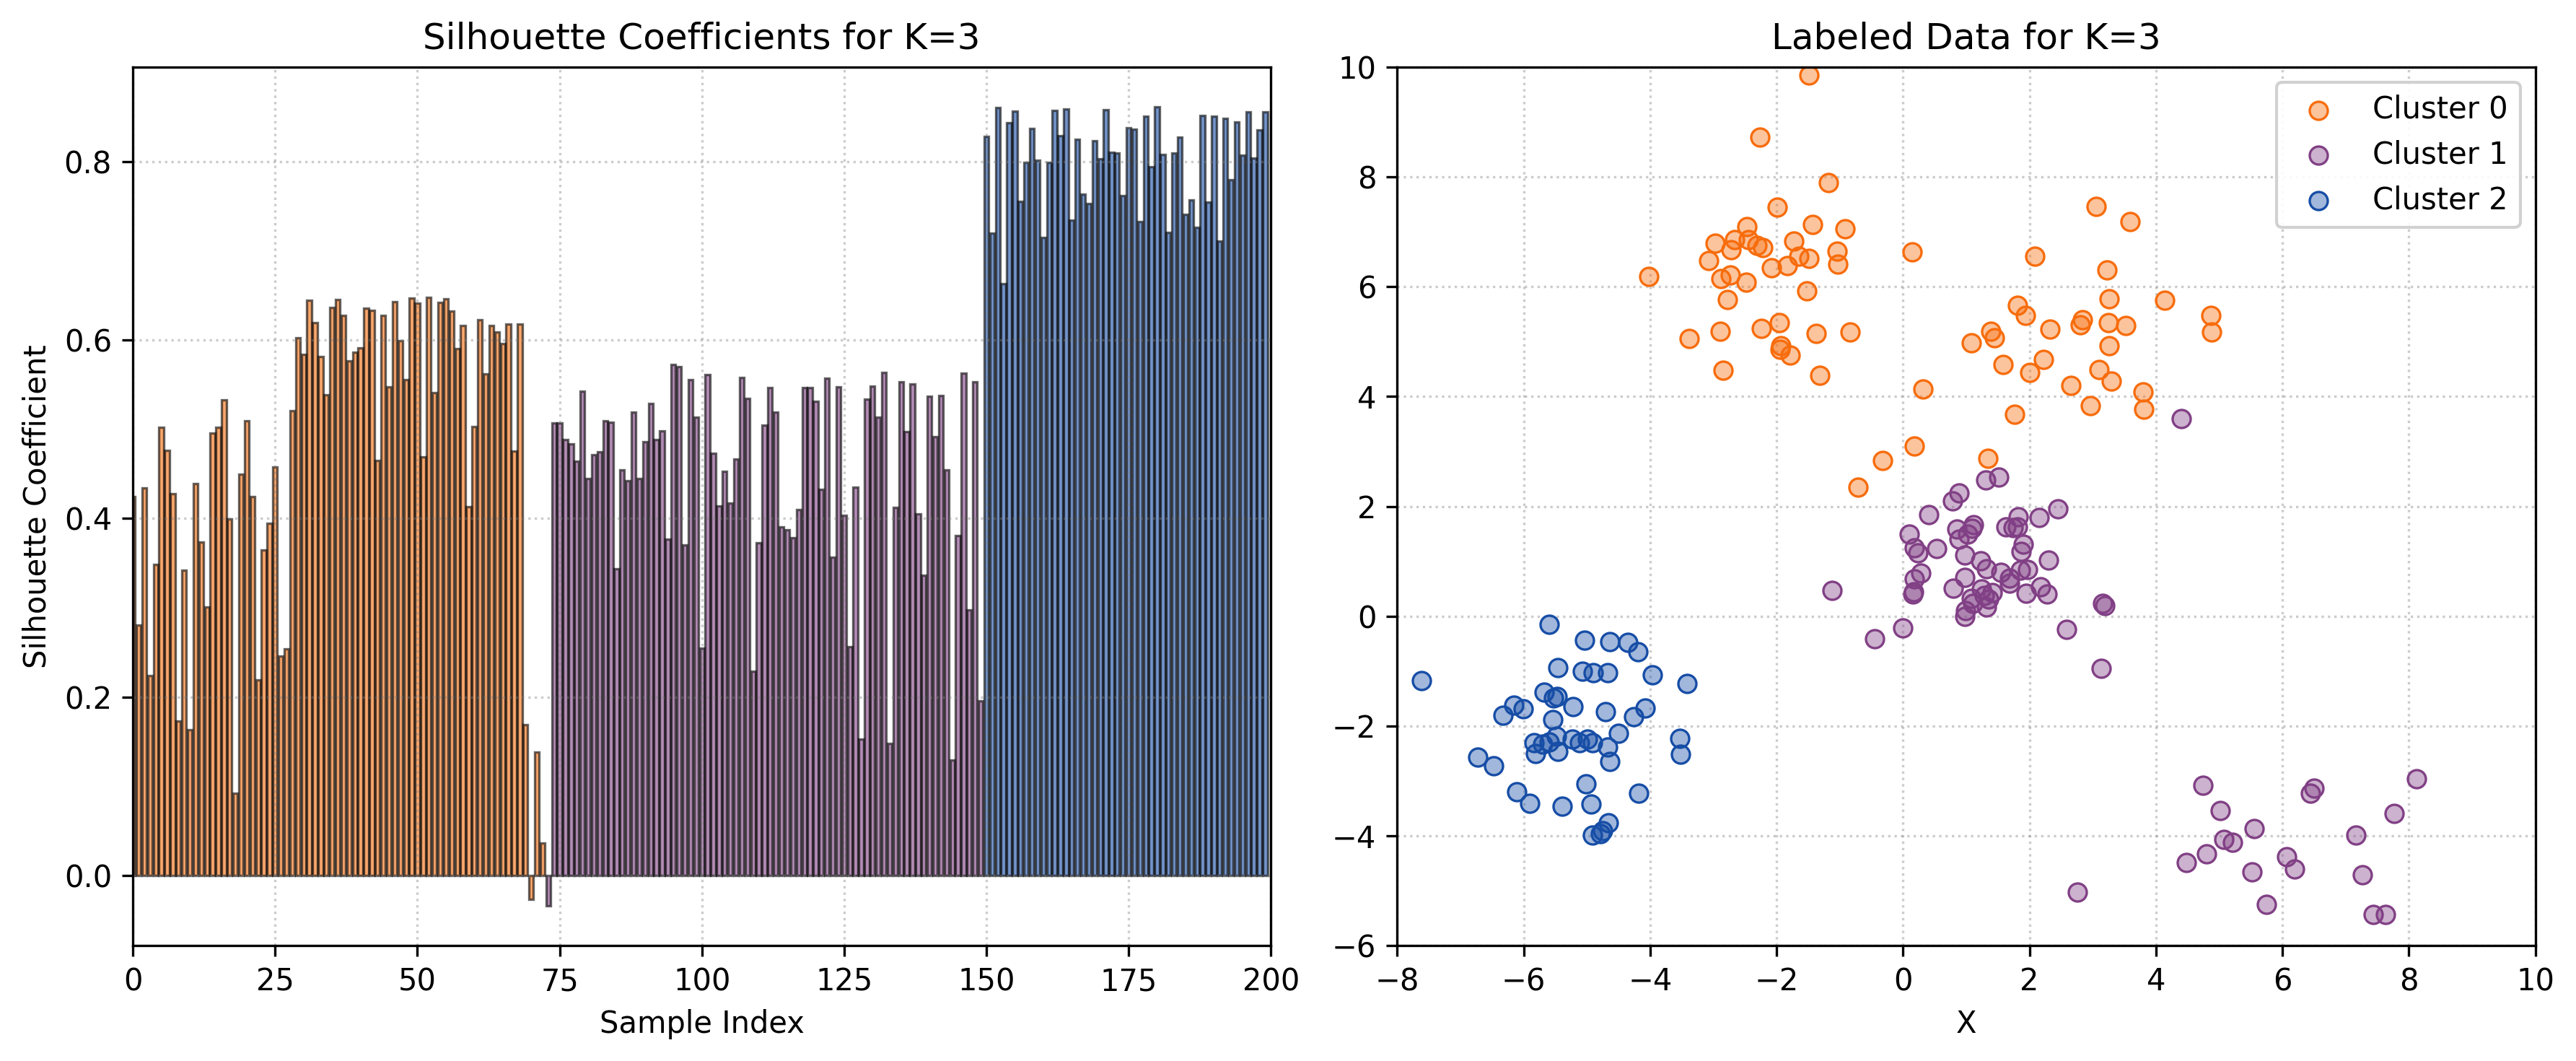

K=4, Silhouette Score=0.6169


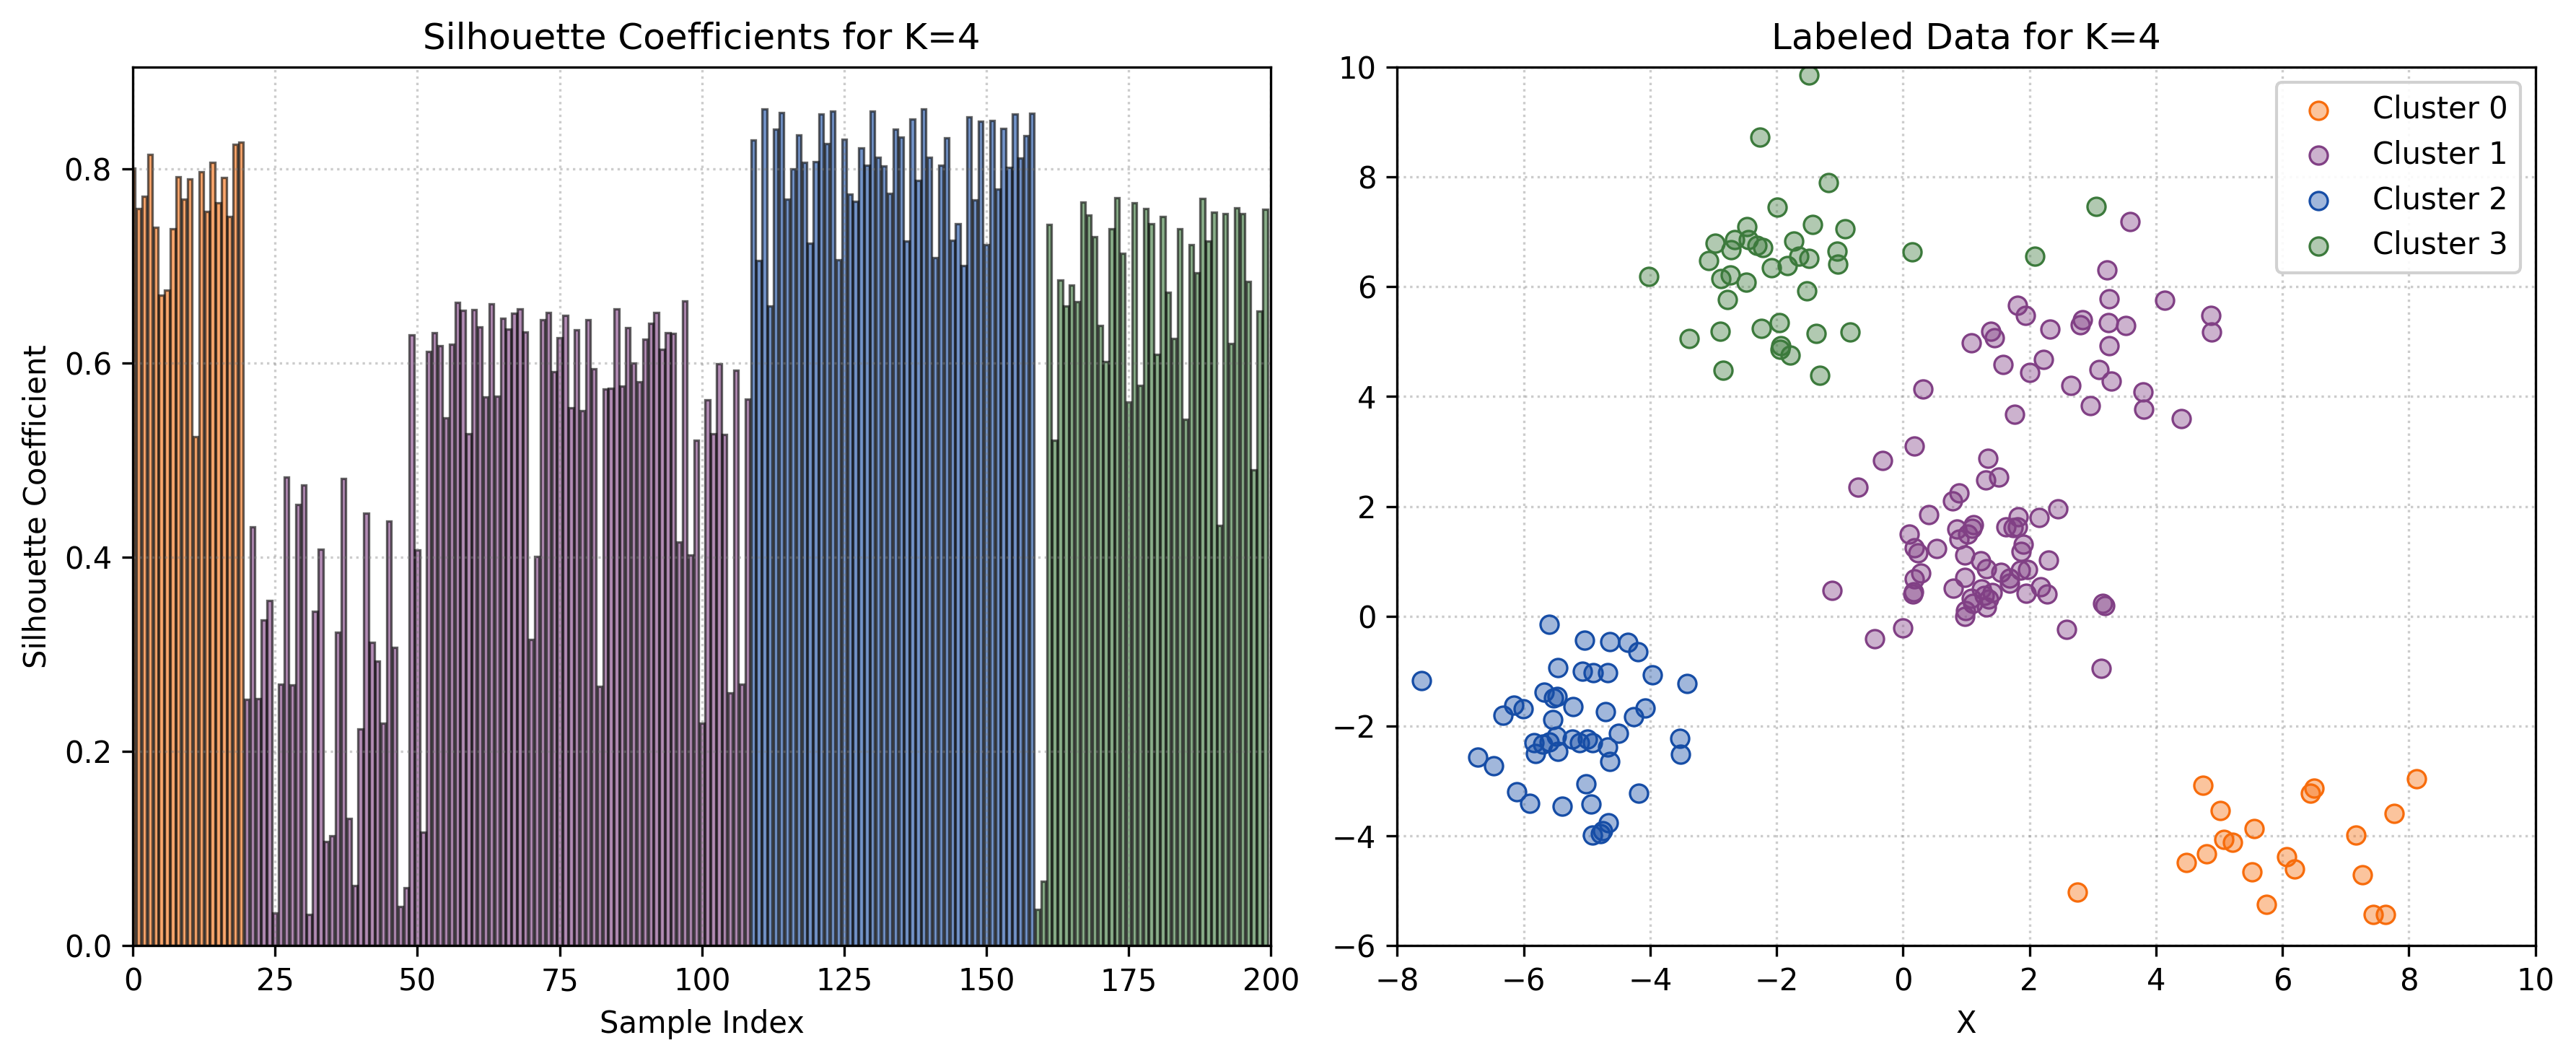

K=5, Silhouette Score=0.6733


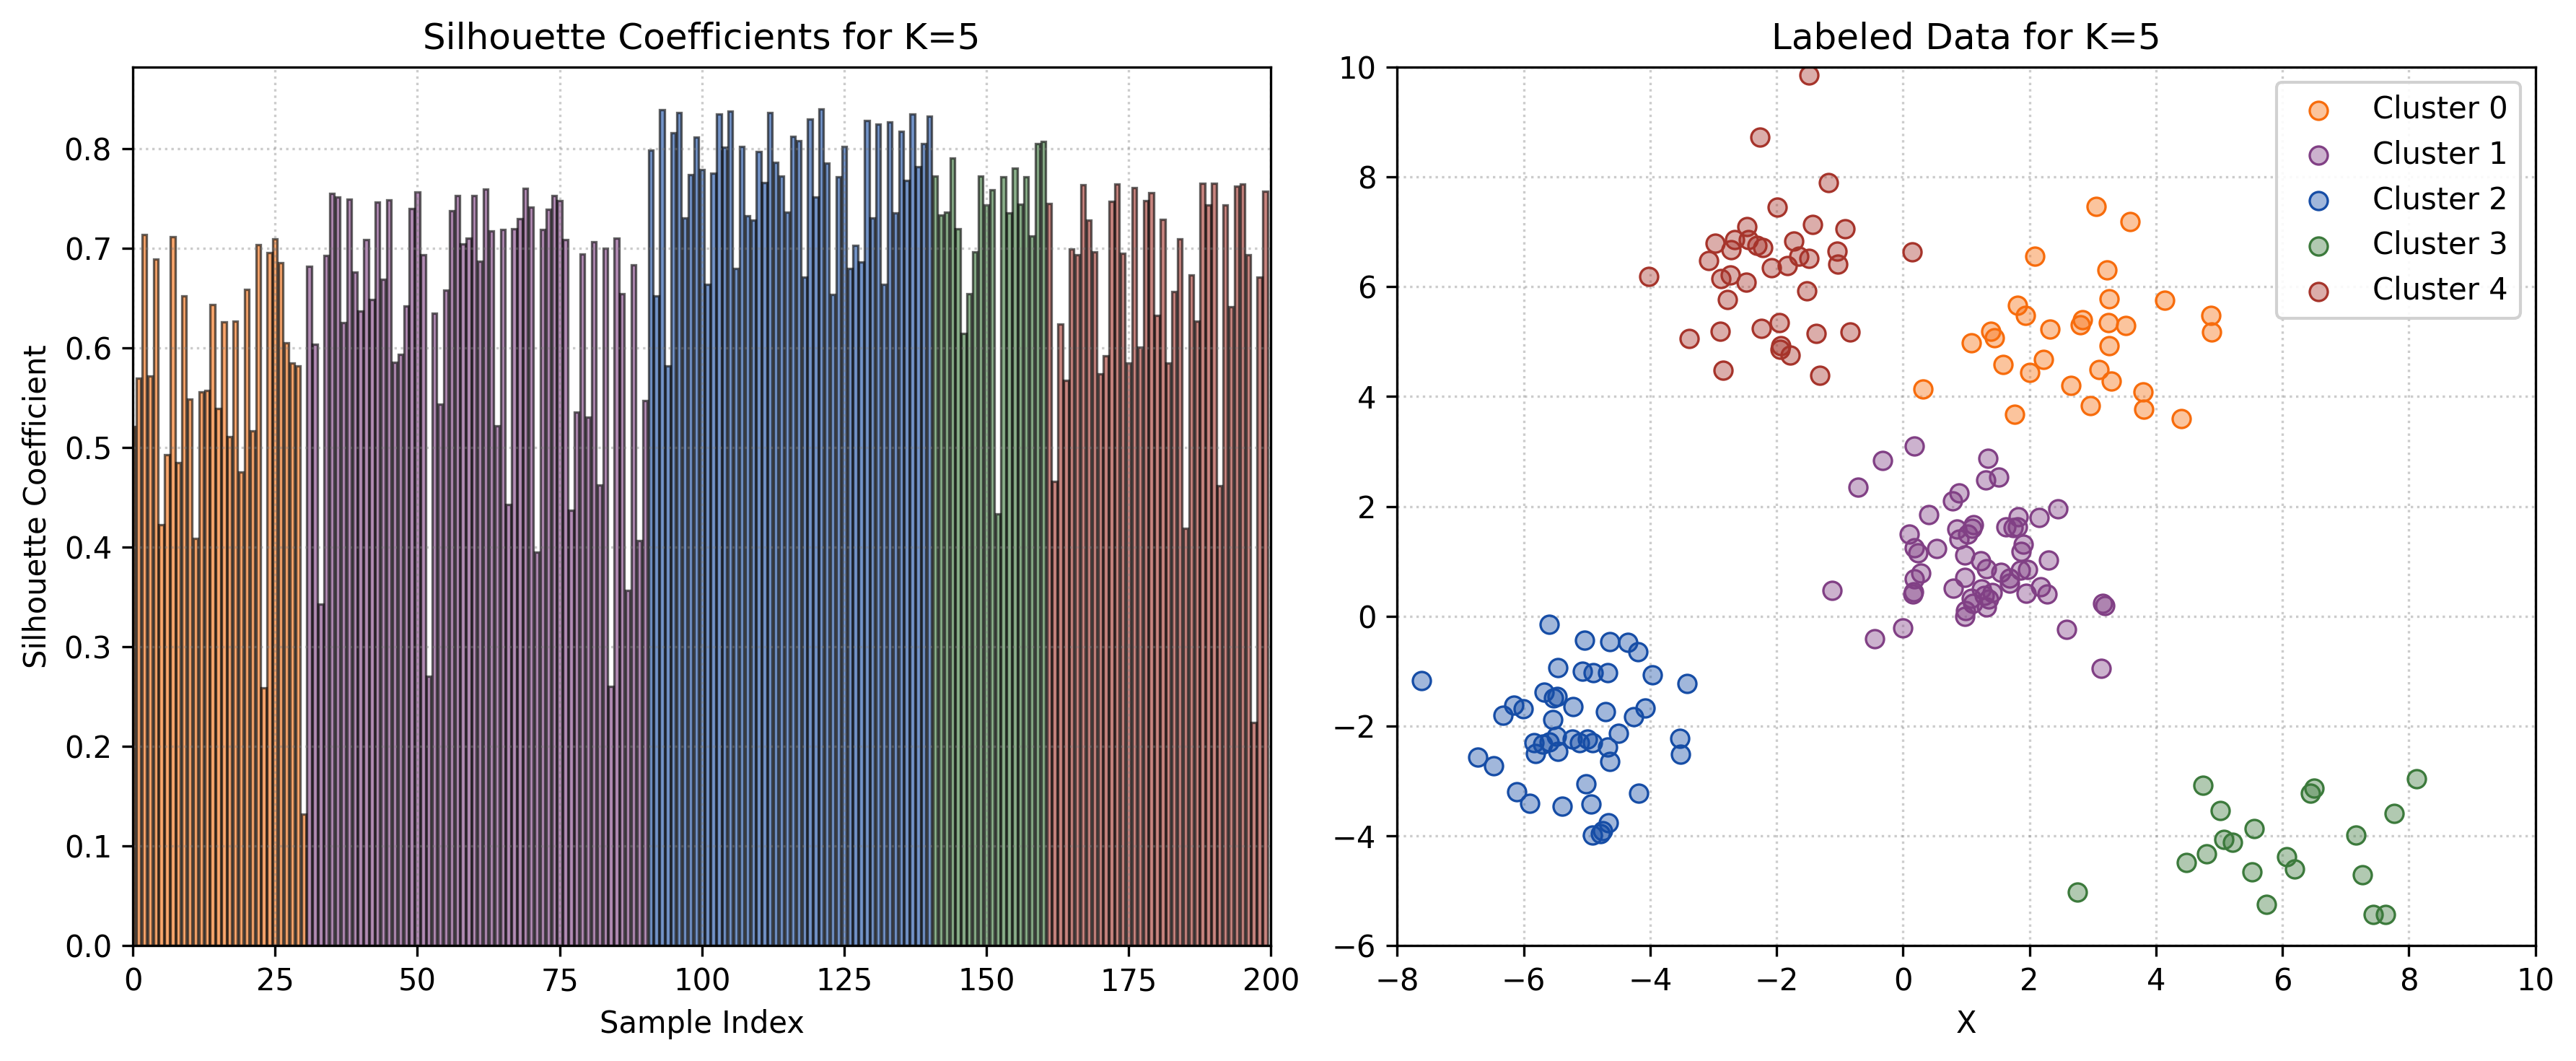

K=6, Silhouette Score=0.5701


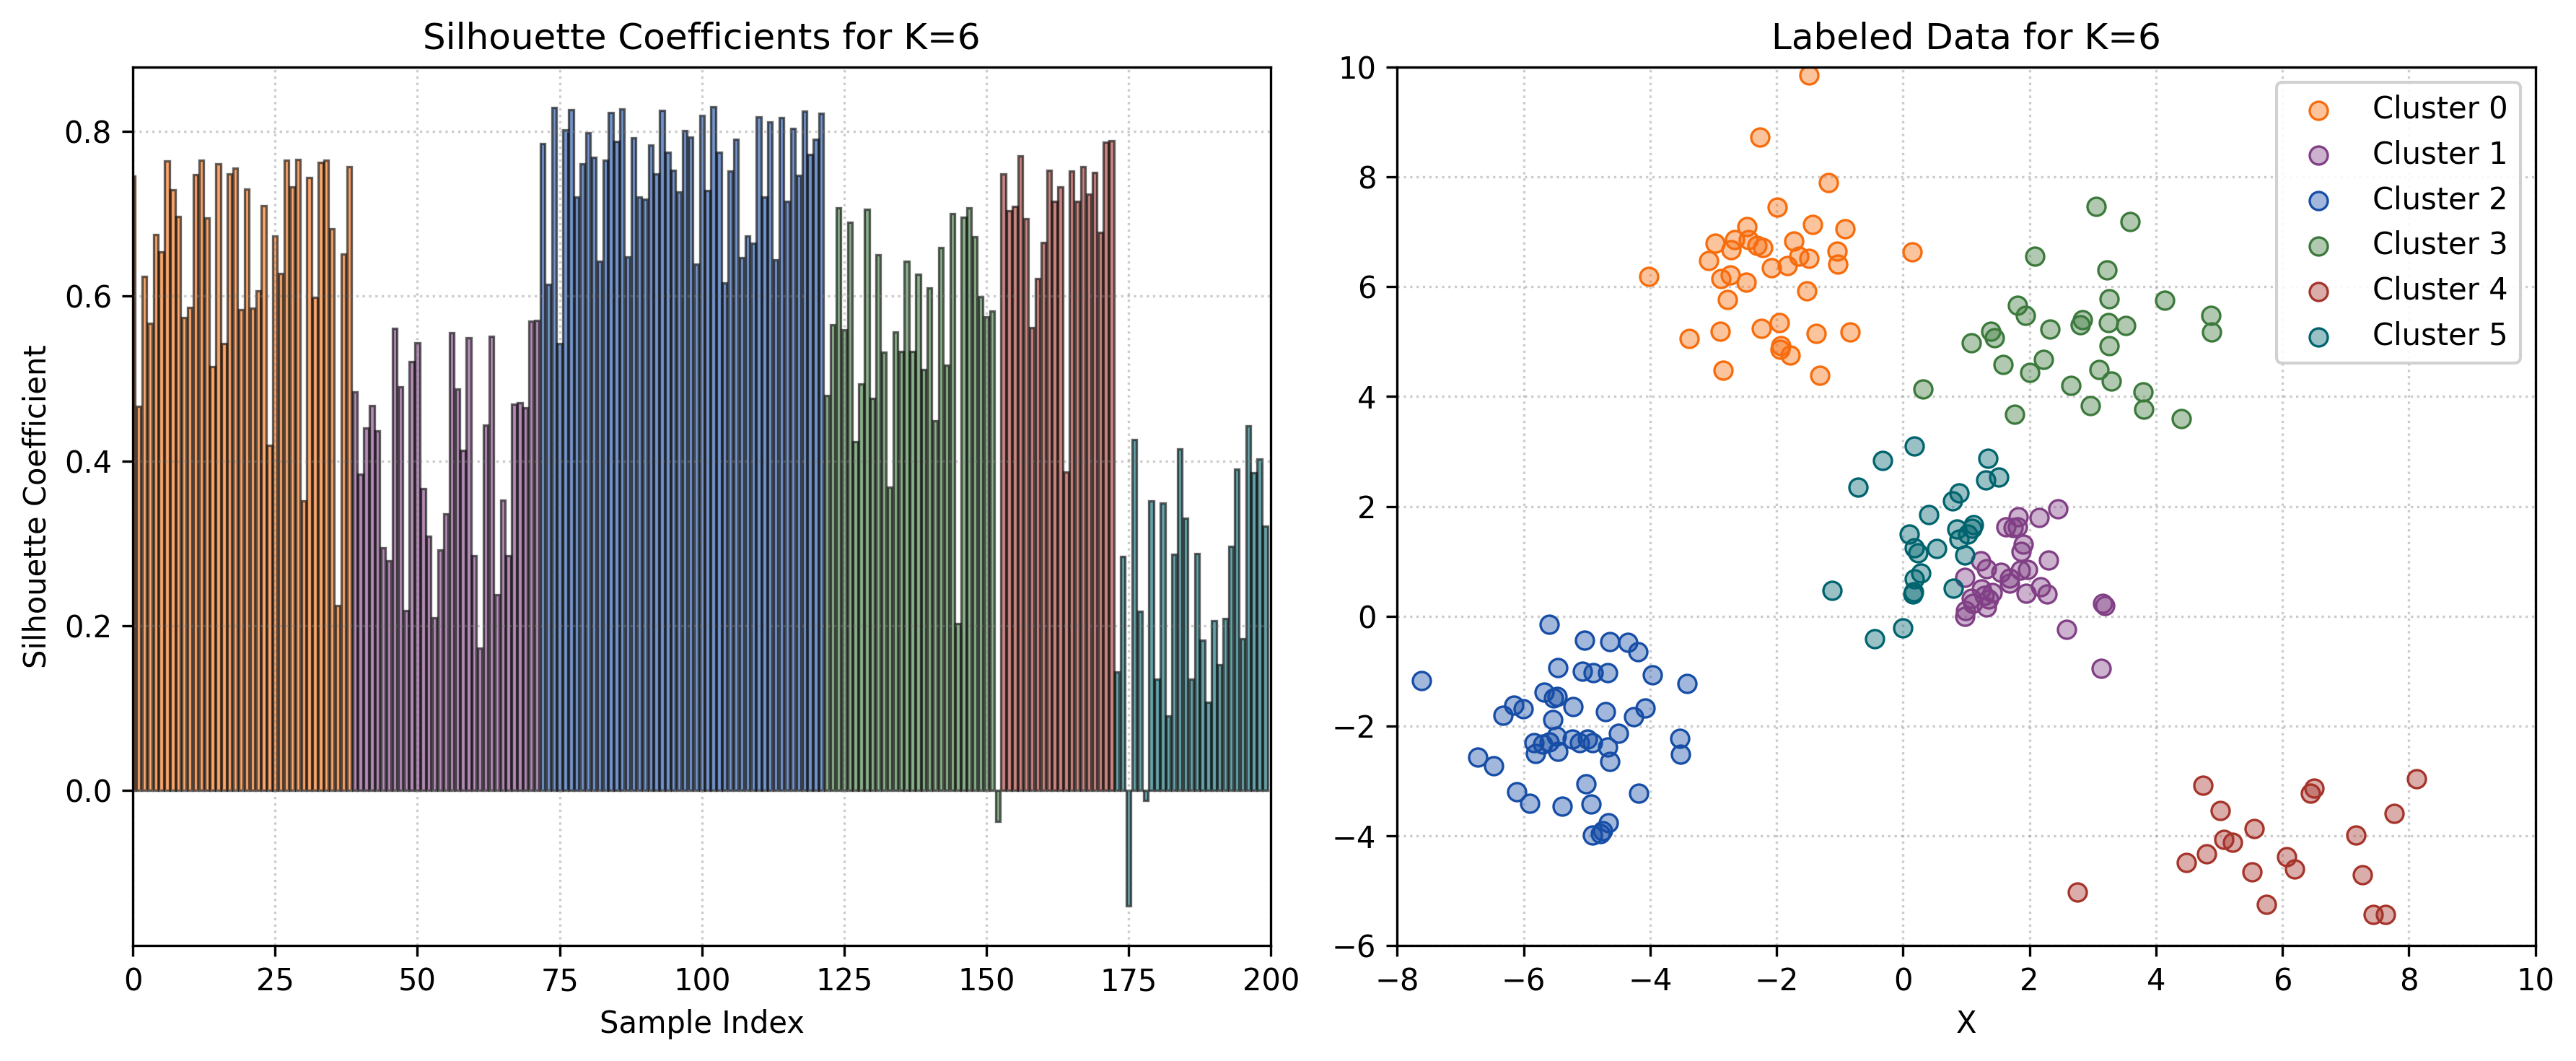

K=7, Silhouette Score=0.4677


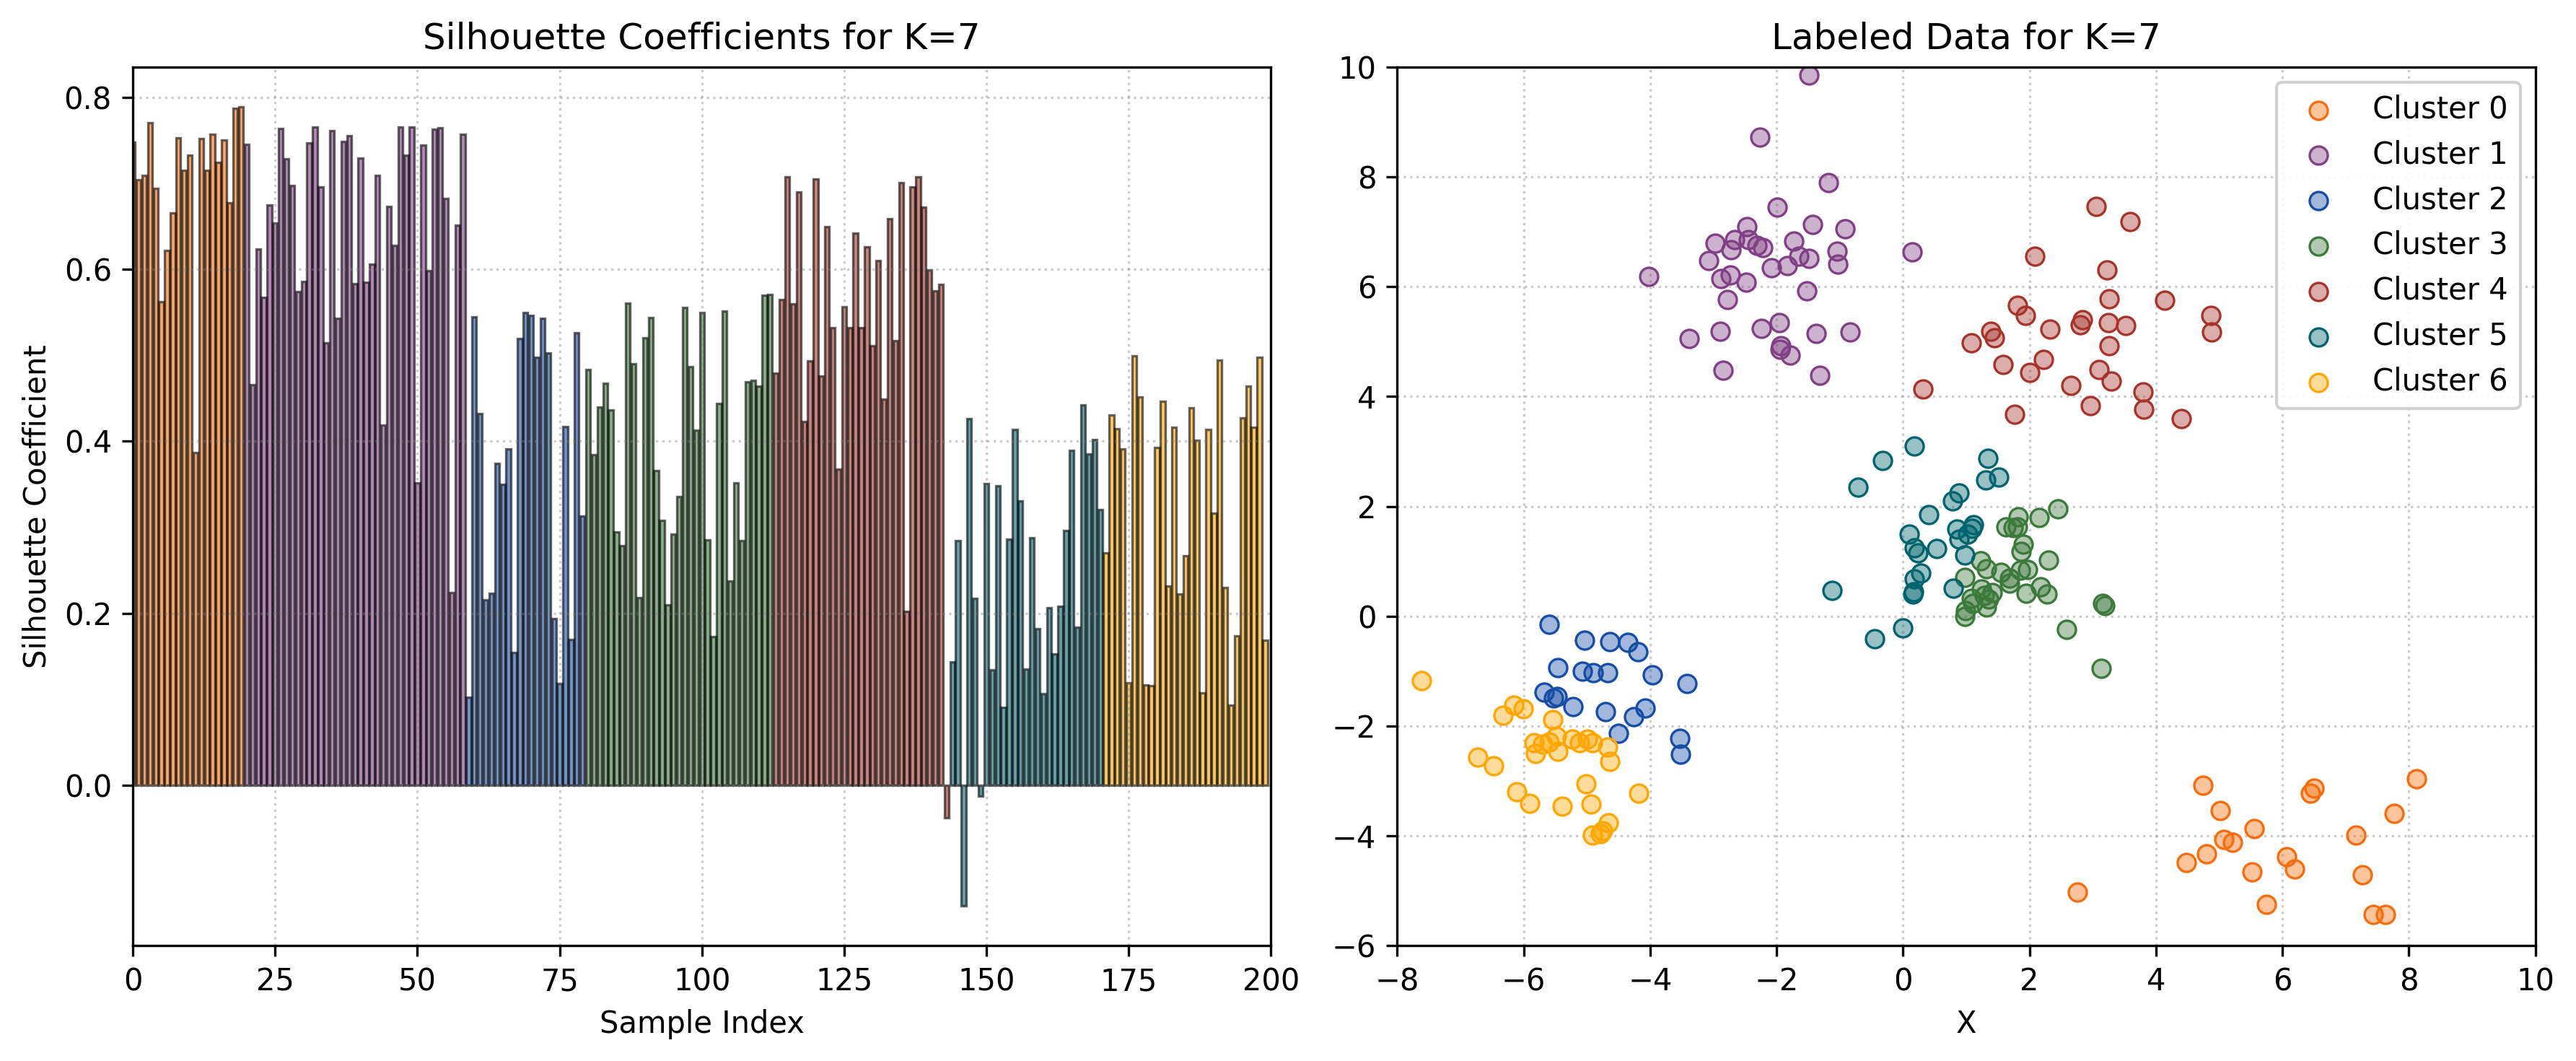

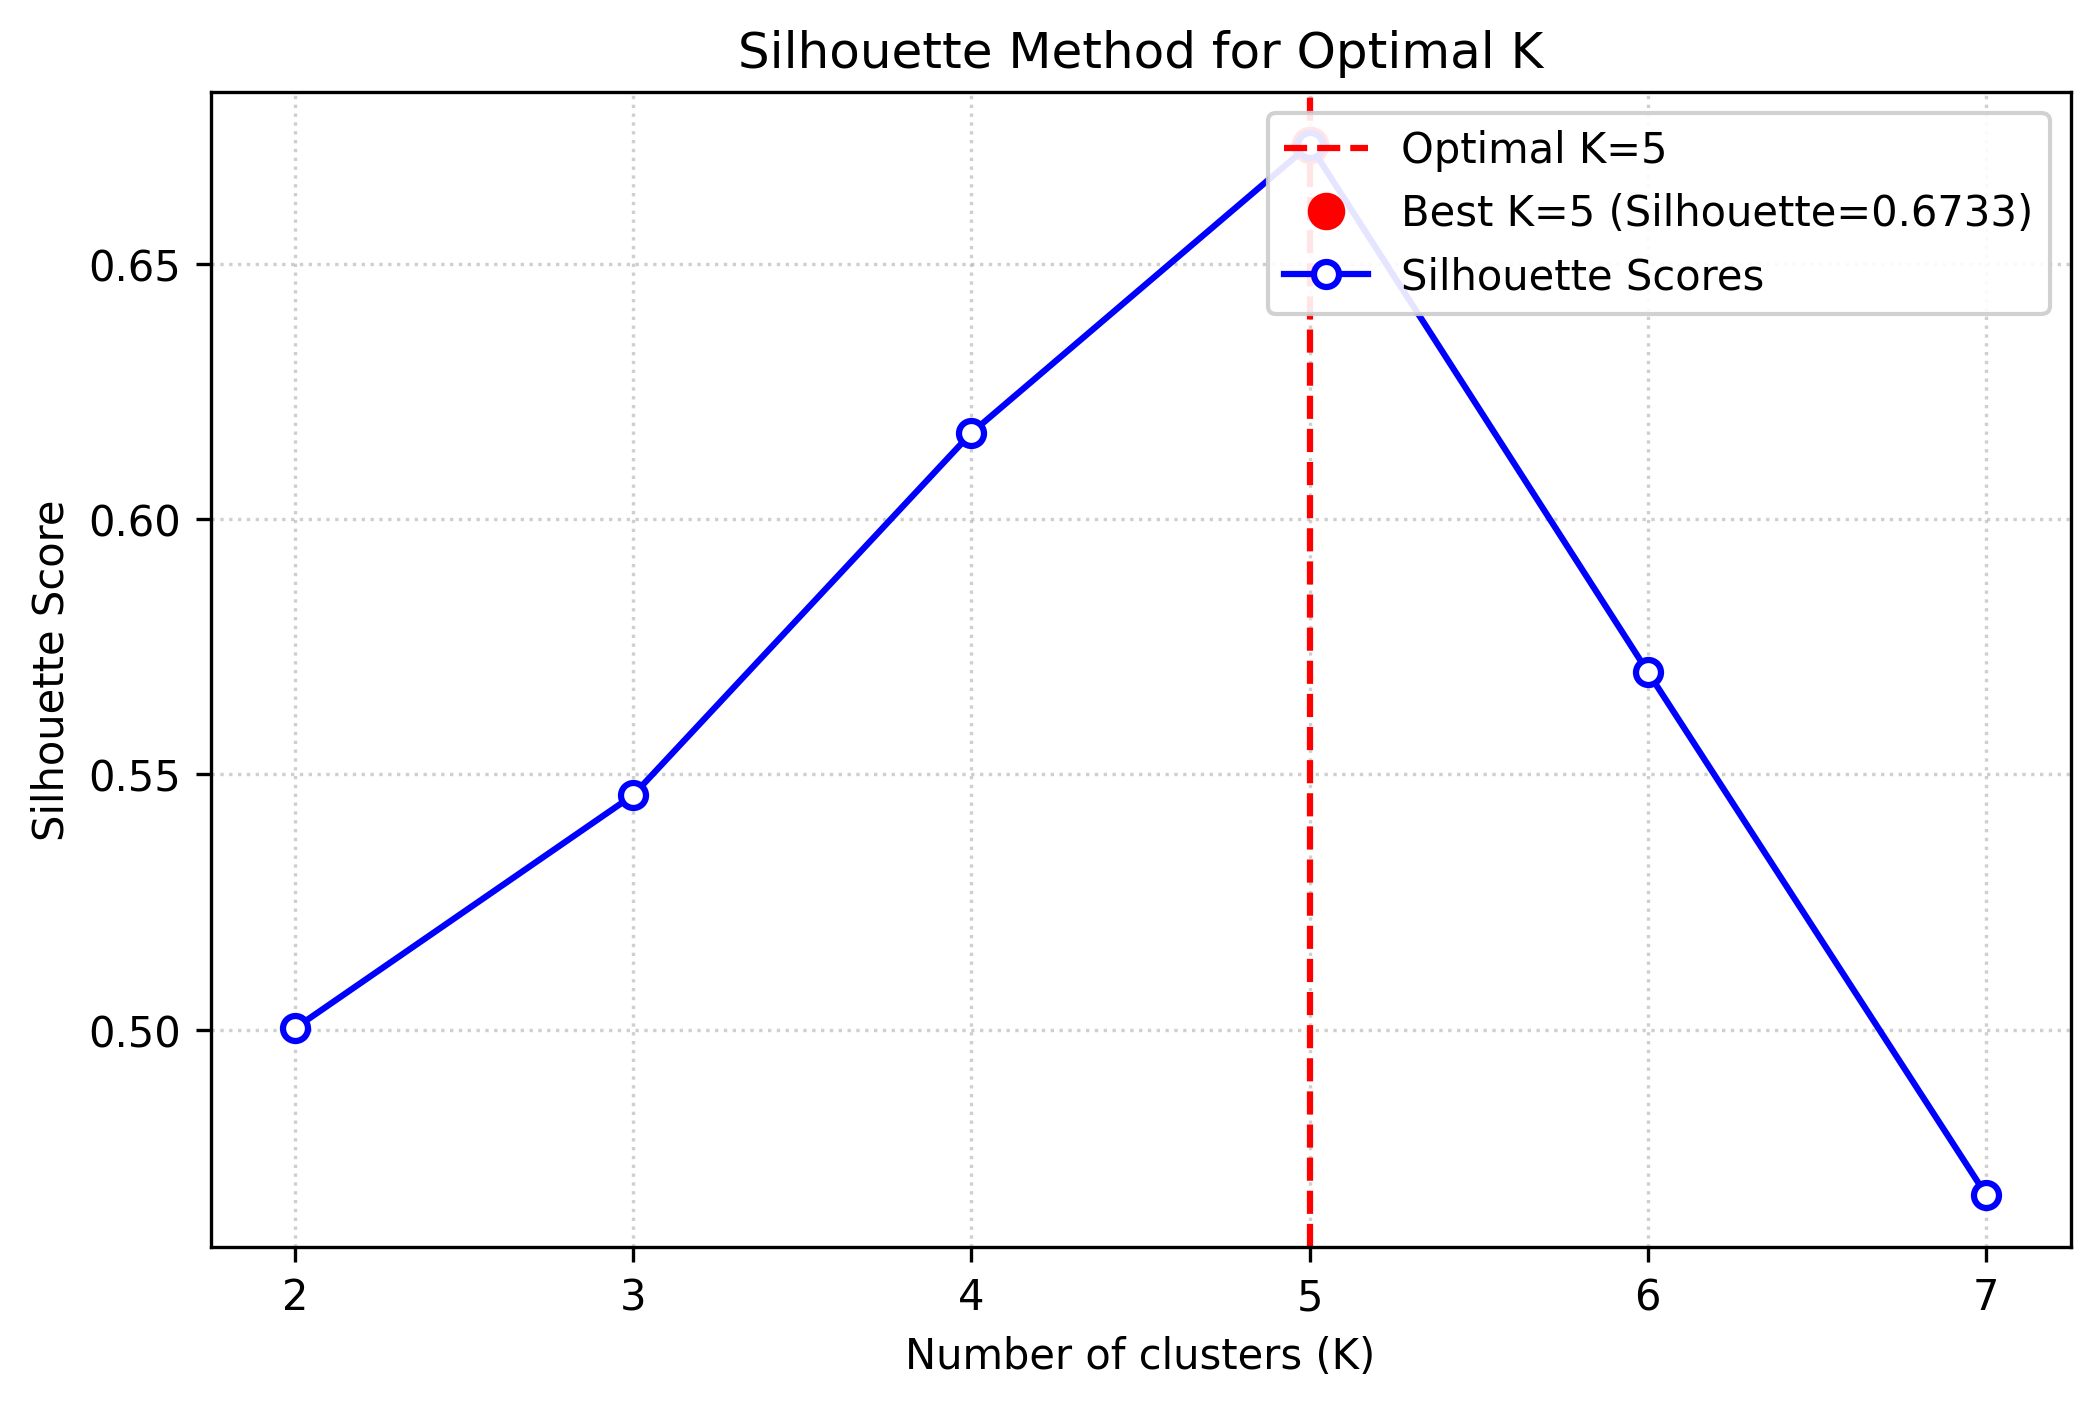

最佳K值为: 5


In [18]:
def silhouette_method(X, max_k=7):
    """ 使用轮廓系数法确定最佳K值 """
    silhouette_scores = []
    k_values = range(2, max_k+1)  # K值从2开始，因为K=1没有意义
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(X)
        labels = kmeans.labels_

        # 计算轮廓系数
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        print(f"K={k}, Silhouette Score={score:.4f}")
        
        # 计算每个点的轮廓系数
        silhouette_values = silhouette_samples(X, labels)
        
        # 绘制左右图
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

        # 左图：每个点的轮廓系数（柱状图），按类分开
        start_idx = 0  # 用来确定每个类在柱状图中的位置
        for i in range(k):
            cluster_silhouette_vals = silhouette_values[labels == i]
            ax1.bar(range(start_idx, start_idx + len(cluster_silhouette_vals)), cluster_silhouette_vals, 
                    color=[(*class_colors[i % len(class_colors)], 0.4)], 
                    edgecolor='black', alpha=0.6, linewidth=0.8, 
                    label=f'Cluster {i}' if i == 0 else "")
            start_idx += len(cluster_silhouette_vals)  # 更新起始位置
        
        ax1.set(xlabel="Sample Index", ylabel="Silhouette Coefficient", title=f"Silhouette Coefficients for K={k}")
        # ax1.legend(loc="upper right", framealpha=0.9)
        ax1.grid(True, linestyle=':', color='gray', alpha=0.4)
        ax1.set_xlim([0, len(X)])
        
        # 右图：带标签数据
        for i in range(k):
            ax2.scatter(X[labels == i, 0], X[labels == i, 1],
                        facecolors=[(*class_colors[i % len(class_colors)], 0.4)],  
                        edgecolors=[class_colors[i % len(class_colors)]], 
                        linewidths=0.8, label=f'Cluster {i}', zorder=2)               
        ax2.legend(loc='upper right', framealpha=0.9)
        ax2.set(xlabel="X", title=f"Labeled Data for K={k}")
        ax2.grid(True, linestyle=':', color='gray', alpha=0.4)
        ax2.set_xlim([-8, 10])
        ax2.set_ylim([-6, 10])

        plt.tight_layout()
        plt.show()

    # 绘制轮廓系数曲线
    plt.figure(figsize=(8, 5), dpi=300)

    # 标记最佳K值
    best_k = k_values[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    plt.axvline(best_k, color='r', linestyle='--', label=f'Optimal K={best_k}')
    plt.plot(best_k, best_score, 'ro', markersize=8, label=f'Best K={best_k} (Silhouette={best_score:.4f})')
    
    # 绘制轮廓系数曲线
    plt.plot(k_values, silhouette_scores, 'bo-', markersize=6, linewidth=1.5, 
             markerfacecolor='white', markeredgewidth=1.5, label='Silhouette Scores')
    
    plt.xlabel('Number of clusters (K)', fontsize=10)
    plt.ylabel('Silhouette Score', fontsize=10)
    plt.title('Silhouette Method for Optimal K', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xticks(k_values)
    plt.legend(loc='upper right', framealpha=0.9)
    plt.show()
    
    print(f"最佳K值为: {best_k}")

# 示例数据生成
silhouette_method(X)

## 方法3:间隔统计量法

K=1, Gap Statistic=0.3774
K=2, Gap Statistic=0.4452
K=3, Gap Statistic=0.6849
K=4, Gap Statistic=0.9735
K=5, Gap Statistic=1.4786
K=6, Gap Statistic=1.4063
K=7, Gap Statistic=1.3096
K=8, Gap Statistic=1.2391
K=9, Gap Statistic=1.2235
K=10, Gap Statistic=1.1822
最佳 K 值为: 5


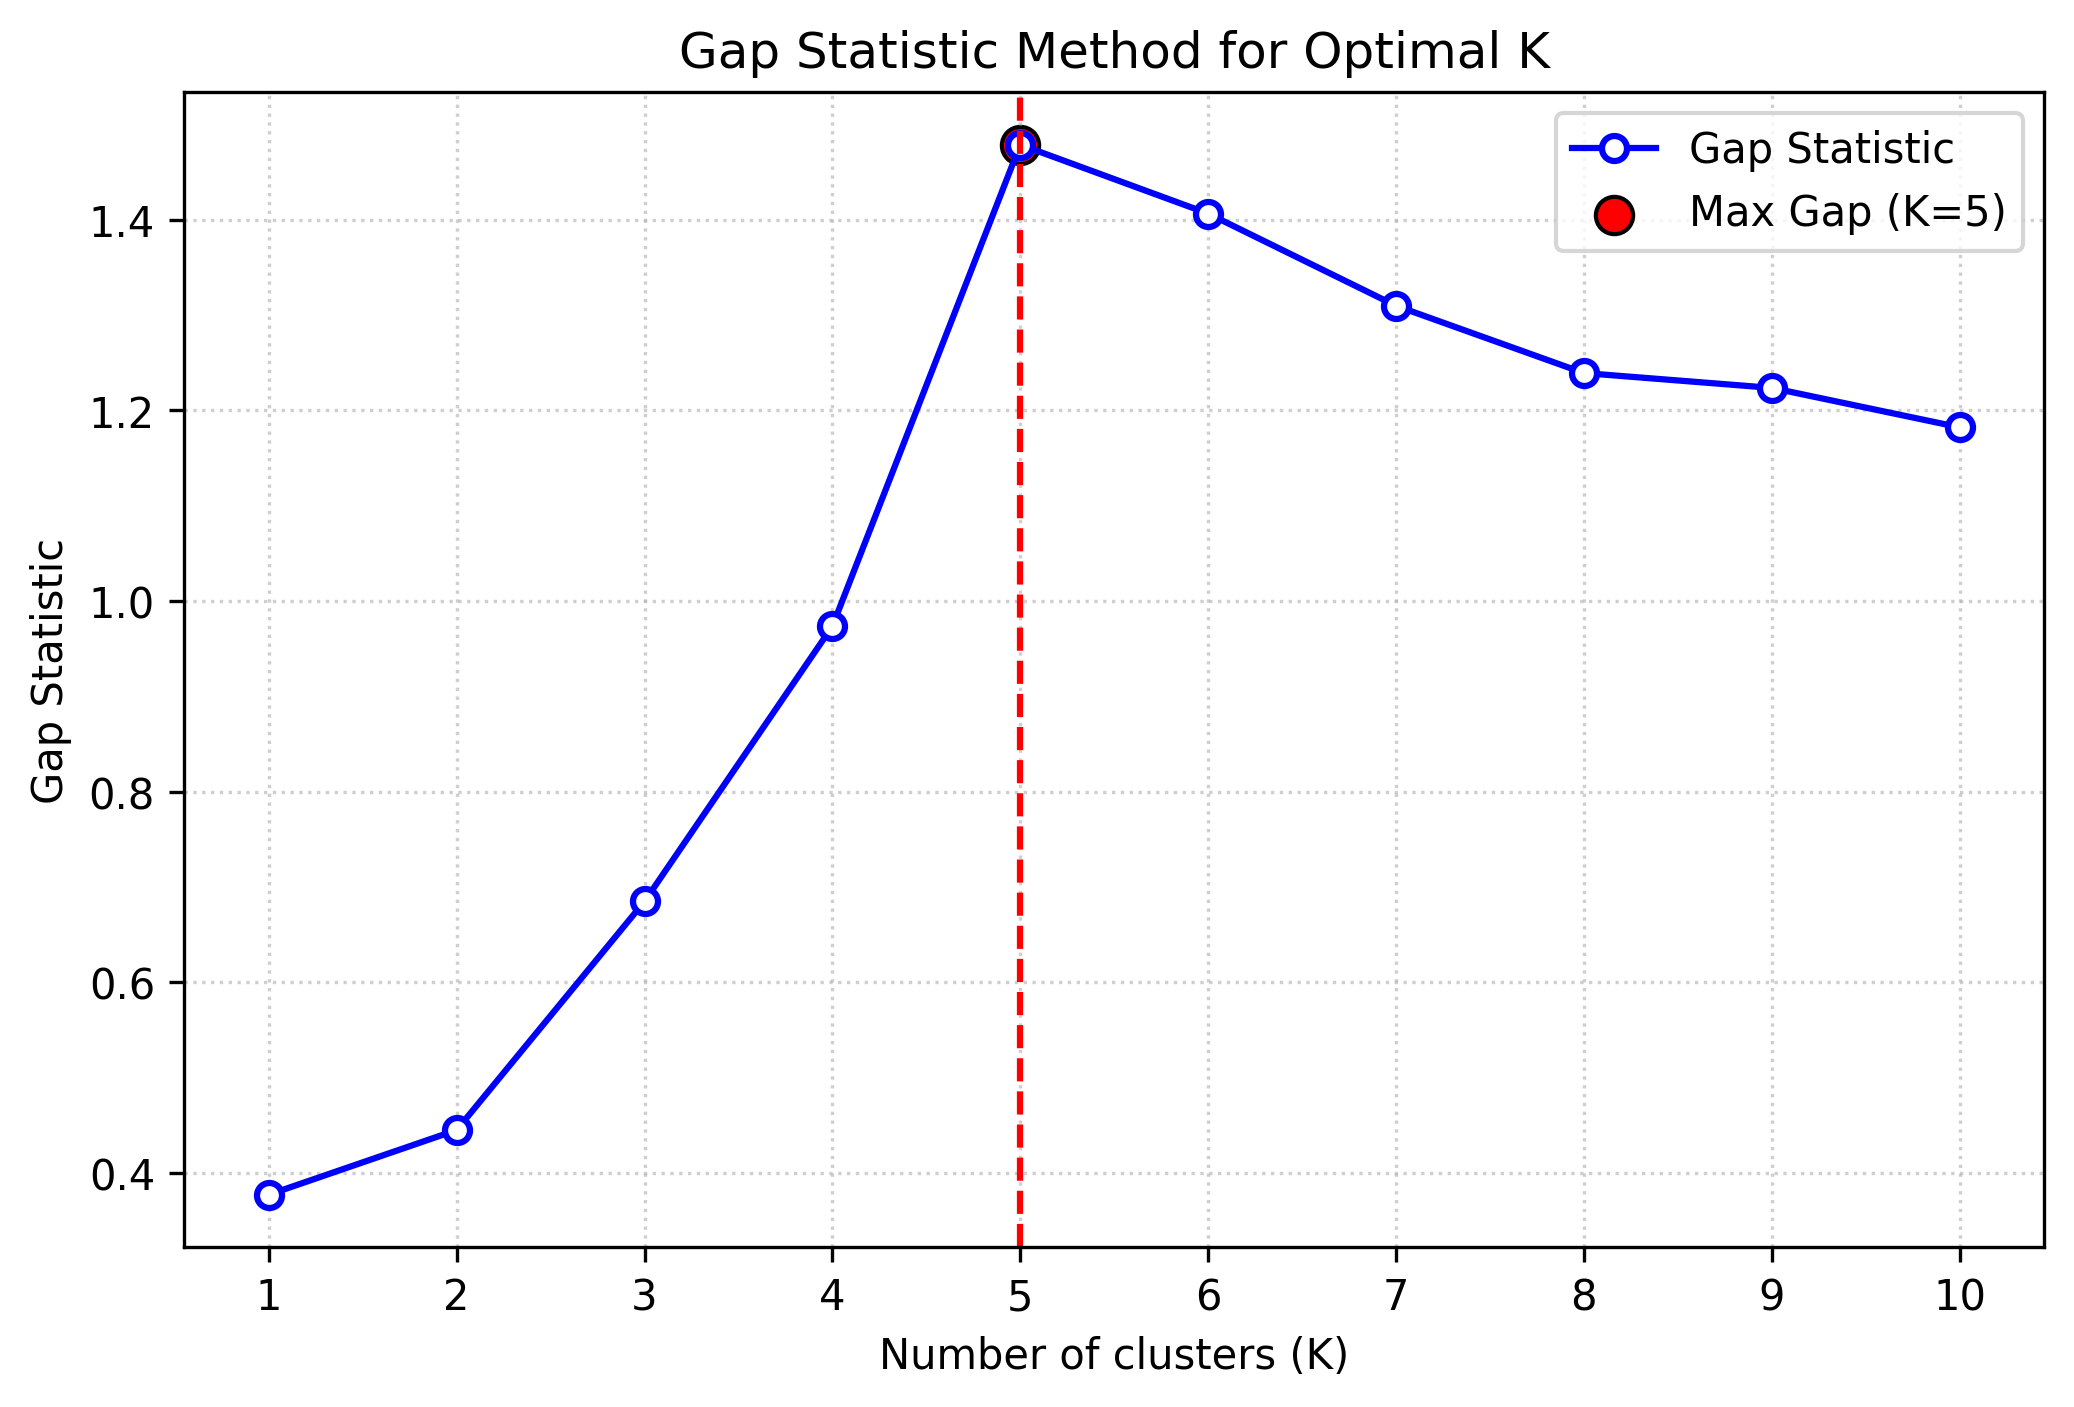

In [19]:
def calculate_Wk(X, k):
    """ 计算 Wk 值，即簇内平方欧几里得距离之和 """
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_  # 直接用 inertia_ 获取 Wk

def gap_statistic(X, max_k=10, n_references=10):
    """ 使用 Gap Statistic 方法确定最佳K值 """
    gaps = []

    for k in range(1, max_k + 1):
        # 计算真实数据的 Wk 值
        Wk_data = calculate_Wk(X, k)

        # 计算随机参考数据的 Wk 值
        Wk_reference = []
        for _ in range(n_references):
            random_data = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), size=X.shape)
            Wk_reference.append(calculate_Wk(random_data, k))

        # 计算 Gap 统计量
        gap = np.mean(np.log(Wk_reference)) - np.log(Wk_data)
        gaps.append(gap)

        print(f"K={k}, Gap Statistic={gap:.4f}")

    # 选择 Gap 最大的 K 值
    best_k = np.argmax(gaps) + 1
    print(f"最佳 K 值为: {best_k}")

    # 绘制 Gap Statistic 曲线，并标出最大值点
    plt.figure(figsize=(8, 5), dpi=300)
    plt.plot(range(1, max_k+1), gaps, 'bo-', markersize=6, linewidth=1.5, markerfacecolor='white', markeredgewidth=1.5, label="Gap Statistic")
    
    # 标记最大 Gap 值
    plt.scatter(best_k, max(gaps), color='red', s=80, edgecolors='black', label=f'Max Gap (K={best_k})')
    plt.axvline(best_k, color='r', linestyle='--')

    plt.xlabel('Number of clusters (K)', fontsize=10)
    plt.ylabel('Gap Statistic', fontsize=10)
    plt.title('Gap Statistic Method for Optimal K', fontsize=12)
    plt.xticks(range(1, max_k+1))
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# 运行 Gap Statistic 方法
gap_statistic(X, max_k=10)